## Rhetorical relations classification

1. Data cleaning: obtain the data and clean it (X, y)
 - transformations: normalization, scaling
2. Classifiers & CV-training for relations classification (cause/background/attribution/etc.)
4. Save the best classifier to ``models/label_predictor/model.pkl``
3. Feature selection
 - Find features with single unique value
 - Find collinear features
4. Classifiers & CV-training for nuclearity classification (NN/NS/SN)

Output:
 - ``models/label_predictor/*``

In [3]:
#! pip install -U pandas==0.24.1
! pip install -Uq pip catboost

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from matplotlib import rcParams
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
from catboost import CatBoostClassifier
from time import time
import pickle

rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

random_state = 42

Using TensorFlow backend.


In [2]:
import glob
import pandas as pd

df = []
for filename in glob.glob("data/*.gold.pkl"):
    tmp = pd.read_pickle(filename)   
    df.append(tmp)

In [3]:
df = pd.concat(df)
df = df.fillna(0.)
constants = [c for c in df.columns if len(set(df[c])) == 1]
to_drop = ['snippet_x', 'snippet_y', 'snippet_x_tmp', 'snippet_y_tmp', 'filename', 'order', 'postags_x', 'postags_y']
df = df.drop(columns=constants)
pickle.dump(constants+to_drop, open('models/label_predictor/drop_columns.pkl', 'wb'))

In [4]:
df.shape

(31491, 2070)

### 1. Data cleaning

In [7]:
TARGET = 'category_id'

df[TARGET] = df[TARGET].replace(['cause-effect_r', 'effect_r'], 'cause_r')
df[TARGET] = df[TARGET].replace(['interpretation-evaluation_r', 'conclusion_r'], 'evaluation_r')

y_stat = df[TARGET].value_counts()
drop_ys = y_stat[y_stat < 500].index

for dy in drop_ys:
    df = df[df[TARGET] != dy]
    
for dy in ['elaboration_r', 'joint_m', 'same-unit_m']:
    df = df[df[TARGET] != dy]

In [8]:
df.shape

(14900, 2070)

In [9]:
df[TARGET].value_counts()

cause_r          2492
contrast_m       1990
condition_r      1646
preparation_r    1625
evaluation_r     1420
sequence_m       1239
purpose_r        1204
attribution_r    1168
evidence_r        796
background_r      723
comparison_m      597
Name: category_id, dtype: int64

In [10]:
#unique_type_list = df[TARGET].unique()
unique_type_list = ['attribution_r', 'purpose_r', 'contrast_m', 'preparation_r', 'sequence_m', 'condition_r', 'cause_r', 'evaluation_r', 'comparison_m', 'evidence_r', 'background_r']
y, X = df[TARGET].to_frame(), df.drop(TARGET, axis=1).drop(columns=to_drop)

In [11]:
categorical_feature_mask = X.dtypes==object
categorical_cols = X.columns[categorical_feature_mask].tolist()
categorical_cols

[]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

lab_encoder = LabelEncoder().fit(unique_type_list)
y = lab_encoder.transform(y)

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y)
        return self
    
lab_encoder = MyLabelEncoder().fit(unique_type_list)
y = lab_encoder.transform(y)

In [17]:
X.shape

(15879, 2057)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder()

X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_ohe = ohe.fit_transform(X[categorical_cols].values)

#X_ohe = pd.DataFrame(X_ohe, X.index, columns=ohe.get_feature_names(categorical_cols))
X_ohe = ohe.fit_transform(X[categorical_cols].values)
X = X.join(
   pd.DataFrame(X_ohe, X.index).add_prefix('cat_'), how='right'
).drop(columns=categorical_cols)

In [19]:
scaler = StandardScaler().fit(X.values)

X_scaled_np = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled_np, index=X.index, columns=X.columns)

X = X_scaled_df

In [21]:
X.shape

(15879, 2057)

### 2. Make different feature sets

In [16]:
# locational = [feat for feat in list(X.keys()) if '_pair_' in feat]
# quantitative = [feat for feat in list(X.keys()) if '_count_' in feat]

# X_quant = X.drop(columns=locational)  # quantitative only 
# X_positional = X.drop(columns=quantitative)  # positional only

# lexical = ['tf_idf_y_167', 'tf_idf_y_114', 'tf_idf_y_97', 'tf_idf_y_46', 'tf_idf_x_291', 'tf_idf_x_261', 'tf_idf_x_118', 'tf_idf_x_97']
# morphosynt = ['last_X_X_y', 'first_X_X_y', 'last_X_NOUN_y', 'first_X_NOUN_y', 'first_X_y', 'first_VERB_X_y', 'first_VERB_PRON_y', 'last_VERB_NOUN_y', 'first_VERB_NOUN_y', 'first_VERB_ADV_y', 'last_VERB_ADP_y', 'first_VERB_ADP_y', 'first_VERB_ADJ_y', 'first_PRON_X_y', 'last_PRON_PRON_y', 'first_PRON_PRON_y', 'last_PRON_NOUN_y', 'first_PRON_NOUN_y', 'first_PART_X_y', 'last_PART_VERB_y', 'first_PART_VERB_y', 'first_NUM_NOUN_y', 'last_VERB_PRON_x', 'first_VERB_X_x', 'last_VERB_ADV_x', 'first_VERB_NOUN_x', 'last_VERB_NOUN_x', 'first_X_NOUN_x', 'last_X_NOUN_x', 'first_X_X_x', 'first_NOUN_VERB_x', 'last_NOUN_VERB_x', 'first_NOUN_X_x', 'last_NOUN_X_x', 'last_NUM_NOUN_x', 'first_PART_VERB_x', 'last_PART_VERB_x', 'first_NUM_NOUN_x', 'last_NOUN_PART_x', 'last_NOUN_NOUN_x', 'first_NOUN_PART_x', 'first_PART_X_x', 'first_PRON_X_x', 'last_PRON_X_x', 'first_VERB_ADJ_x', 'last_VERB_ADJ_x', 'first_VERB_ADP_x', 'last_VERB_ADP_x', 'last_PRON_PRON_x', 'first_PRON_NOUN_x', 'last_PRON_NOUN_x', 'first_PRON_PRON_x', 'last_NOUN_ADV_x', 'last_NUM_NOUN_y', 'first_ADP_ADJ_x', 'last_ADJ_X_x', 'last_ADJ_NOUN_x', 'fPOS_CONJ_y', 'fPOS_ADV_y', 'last_ADV_ADV_x', 'last_ADP_NOUN_x', 'first_ADP_NOUN_x', 'last_ADP_ADJ_x', 'fPOS_ADJ_y', 'first_ADJ_NOUN_y', 'first_ADJ_X_y', 'first_ADP_ADJ_y', 'last_ADP_ADJ_y', 'first_ADP_NOUN_y', 'last_ADP_NOUN_y', 'first_ADV_NOUN_y', 'Case_Ins_x', 'first_ADV_VERB_y', 'first_ADV_X_y', 'last_ADV_X_y', 'first_CONJ_NOUN_y', 'first_CONJ_X_y', 'first_NOUN_ADJ_y', 'last_NOUN_ADJ_y', 'first_NOUN_ADV_y', 'last_NOUN_NOUN_y', 'first_NOUN_VERB_y', 'first_NOUN_X_y', 'last_NOUN_X_y', 'first_ADV_ADV_y', 'Voice_Pass_y', 'VerbForm_Inf_y', 'VerbForm_Ger_y', 'fPOS_PRON_x', 'fPOS_ADV_x', 'Comparision_Sup_y', 'last_CONJ_X_x', 'last_ADV_X_x', 'first_CONJ_NOUN_x', 'first_ADV_X_x', 'first_CONJ_X_x', 'first_NOUN_ADV_x', 'last_NOUN_ADJ_x', 'last_CONJ_NOUN_x', 'first_NOUN_ADJ_x', 'last_PART_X_x', 'last_CONJ_ADV_y', 'last_ADJ_X_y', 'last_ADV_ADV_y', 'last_VERB_X_x', 'last_NOUN_ADV_y', 'first_CONJ_ADV_y', 'last_X_X_x', 'last_VERB_ADV_y', 'last_VERB_PRON_y', 'last_NOUN_PART_y', 'first_ADV_VERB_x', 'fPOS_VERB_y', 'last_ADJ_NOUN_y', 'first_ADV_ADV_x', 'fPOS_ADP_y', 'first_VERB_ADV_x', 'first_NOUN_NOUN_y', 'morph_correlation']
# textual = ['\\bтам_count_X', '\\bв\\b_count_X', '\\bеще_count_X', 'полагаем_count_X', '\\bпока\\b_count_X', 'поз(?:дн|же)_count_X', 'позволяющ_count_X', 'позволя_count_X', 'подход_count_X', 'последн_count_X', 'подразумевает_count_X', '\\bпод\\b_count_X', '\\bпо\\b_count_X', 'переда_count_X', 'перед_count_X', 'первоначально_count_X', 'ошибкой_count_X', 'очередь_count_X', 'получаем_count_X', 'поможет_count_X', 'порожда_count_X', 'при условии_count_X', 'прежде_count_X', 'проявля_count_X', 'предъяв_count_X', 'представ_count_X', 'предназначен_count_X', 'пределами_count_X', 'правда_count_X', 'похож(?:ий|ая|ие|ее)_count_X', 'послужи_count_X', 'порожд_count_X', 'отчасти_count_X', 'обстоятельств_count_X', 'образцы_count_X', 'обнаружил_count_X', 'обнаружи_count_X', 'обеспечивающ_count_X', 'обеспечива_count_X', 'обвини_count_X', '\\bоб?\\b_count_X', '\\bно и\\b_count_X', '\\bних\\b_count_X', 'неясн_count_X', 'несомненн_count_X', 'несмотря_count_X', 'неразумн_count_X', 'необходим_count_X', 'обусловл_count_X', 'объясн_count_X', 'обязательн_count_X', 'отреагирова_count_X', 'отправной_count_X', 'отмеч_count_X', 'отмети_count_X', 'отместку_count_X', 'отличи_count_X', '\\bот\\b_count_X', 'приводи_count_X', 'особ_count_X', 'определ_count_X', 'оправдыва_count_X', 'опасаться_count_X', 'одним_count_X', '(?:один|одна|одно|одни)_count_X', 'особенн_count_X', 'призна_count_X', '\\bстать\\b_count_X', '\\bстав\\b_count_X', 'состоять_count_X', 'составе_count_X', 'сопровождении_count_X', 'сомневаться_count_X', 'совместно_count_X', 'случа_count_X', 'слову_count_X', '\\bисходя\\b_count_X', 'слишком_count_X', 'следующим_count_X', 'степени_count_X', '\\bтон\\b_count_X', '\\bтому\\b_count_X', 'только_count_X', 'толчком_count_X', 'теперь_count_X', '\\bтак(?:ие|им|их|ов|ой|ая|ое)\\b_count_X', '\\bтакже\\b_count_X', 'считать,_count_X', 'считать_count_X', 'счету_count_X', '\\bсути\\b_count_X', '\\bсудя\\b_count_X', 'тогда_count_X', 'немедленн_count_X', '\\bследу_count_X', '\\bследстви_count_X', 'район_count_X', 'разумеется_count_X', 'разделя_count_X', 'разве_count_X', 'равно_count_X', 'пути_count_X', 'пусть_count_X', 'противоположн_count_X', 'против_count_X', 'просто_count_X', 'проблемы_count_X', 'причем_count_X', 'приходится_count_X', 'пример_count_X', 'применительно_count_X', 'ранее_count_X', 'скорее_count_X', 'сказаться_count_X', 'сказать,_count_X', 'связан_count_X', 'сведениям_count_X', '\\bс тем\\b_count_X', 'ряде_count_X', 'роль_count_X', 'речь_count_X', 'рассказ(?:а|ыва)_count_X', '\\bсам[ое]_count_X', 'вместо_count_X', 'включи_count_X', '\\bвидно\\b_count_X', '\\bвидимо\\b_count_X', '\\bвид.?\\b_count_X', 'ввиду_count_X', '\\bважн_count_X', '\\bв чем\\b_count_X', '\\bв целом_count_X', '\\bбыл\\b_count_X', '\\bбы\\b_count_X', 'будь_count_X', 'будучи_count_X', 'больш[оаи]_count_X', 'гарантирова_count_X', 'вышесказан_count_X', 'высказ(ыв)?ать_count_X', 'вывод[ау]_count_X', '\\bвывод\\b_count_X', 'выби?ра_count_X', '\\bвтор_count_X', 'всяком_count_X', 'вследствие_count_X', '\\bвслед\\b_count_X', 'вскоре_count_X', 'всего_count_X', 'вряд(?: ли)_count_X', '\\bвот\\b_count_X', 'возникающ_count_X', 'возможность_count_X', 'бесспорно_count_X', '\\(_count_X', '\\bэто_count_X', '\\bтом\\b_count_X', '\\bтем\\b_count_X', '\\bте_count_X', '\\bта_count_X', '\\bсо\\b_count_X', '\\bситуаци_count_X', '\\bсамым\\b_count_X', '\\bс\\b_count_X', '\\bрода\\b_count_X', '\\bнего_count_X', '\\bза\\b_count_X', '\\bже\\b_count_X', '\\(.+\\)_count_X', '\\)_count_X', '\\bаналогичн_count_X', '\\bанализ\\b_count_X', '\\bа\\b_count_X', '\\bзаканчива_count_X', '^[-—]_count_X', '\\bгде\\b_count_X', '«_count_X', '\\[_count_X', '\\?_count_X', ':_count_X', '\\\\-_count_X', ',$_count_X', 'где [a-zа-я ]+ [—-]_count_X', '\\bговори.?\\b_count_X', '\\bмере\\b_count_X', 'между_count_X', 'маловероятн_count_X', '\\bлица\\b_count_X', 'линии_count_X', 'кроме э?того_count_X', 'котор_count_X', 'концов_count_X', 'комментари_count_X', '\\bко(?:й|ю|я|ем)\\b_count_X', 'когда_count_X', '\\bко?\\b_count_X', 'как(?:ая|ой|ое|ие)_count_X', '\\bих\\b_count_X', 'месте_count_X', 'мире_count_X', '\\bне только_count_X', 'настаива_count_X', 'например_count_X', 'напомни_count_X', 'написа_count_X', 'намека_count_X', 'надеяться_count_X', '\\bна\\b_count_X', 'мотиваци(?:я|ей)_count_X', 'момента_count_X', 'можно_count_X', 'может_count_X', '\\bмог_count_X', 'неизменно_count_X', 'иными?_count_X', 'доказыв_count_X', 'довольно_count_X', 'добавля_count_X', 'добави_count_X', '\\bдо\\b_count_X', 'для\\b_count_X', 'делят_count_X', 'делать_count_X', '\\bдела.т\\b_count_X', '\\bдела_count_X', 'действительно_count_X', 'дальше_count_X', '\\bдал\\b_count_X', '\\bдавать\\b_count_X', '\\bдава_count_X', 'грани_count_X', 'говорят?_count_X', 'допустим_count_X', '\\bему\\b_count_X', 'есть_count_X', 'информаци_count_X', 'интерес\\b_count_X', 'ин[?:ое|ой|ая]_count_X', 'иногда_count_X', 'иначе_count_X', 'имени_count_X', '\\bили\\b_count_X', 'известно_count_X', 'исключением_count_X', '\\bиз\\b_count_X', 'здесь_count_X', 'затем_count_X', 'застав[ли]_count_X', 'завери_count_X', 'очевидно_count_X', '\\bлибо\\b_count_X', 'невзирая_count_X', 'нетрудн_count_X', '\\._count_X', 'заключа_count_X', 'соответств_count_X', 'наряду_count_X', 'сдела_count_X', 'следовательно_count_X', 'подчерк_count_X', 'результат_count_X', 'объект_count_X', 'свете_count_X', 'писа_count_X', 'сыграть_count_X', '\\bведь\\b_count_X', 'противном_count_X', 'привести_count_X', 'из-за_count_X', 'столько_count_X', 'раздел_count_X', 'некотор_count_X', '(?:то есть|т\\\\. ?е\\\\.)_count_X', 'объяви_count_X', 'сказа_count_X', 'заяв(?:и|ля)_count_X', '\\bодной\\b_count_X', '\\bа с\\b_count_X', 'поэтому_count_X', '\\bвключая\\b_count_X', 'логично_count_X', '\\bне[е|ё]_count_X', 'получа_count_X', 'названи(?:ем|ям|ю)_count_X', 'свидетельств_count_X', 'ради_count_X', '\\bмомент\\b_count_X', 'назва_count_X', 'начн_count_X', 'включа_count_X', 'почему_count_X', 'отчего_count_X', 'причин_count_X', '\\?$_count_X', 'име(?:я|ем|ет|ют)_count_X', 'настоящ_count_X', 'способств_count_X', '\\bвидим\\b_count_X', '\\bобщ[иеу]_count_X', '\\bтой\\b_count_X', 'впрочем_count_X', 'больше_count_X', 'во многом_count_X', 'источником_count_X', 'насколько_count_X', '- ?_count_X', 'имя_count_X', 'получим_count_X', 'потребова_count_X', 'откуда_count_X', 'завис[и|я]_count_X', 'впоследствии_count_X', ',_count_X', 'преддверии_count_X', 'обозначи_count_X', 'главе_count_X', 'значит_count_X', 'потому_count_X', 'ранн(?:ий|яя|ее|ие)_count_X', 'описывать_count_X', '\\bисточник\\b_count_X', 'сообщи_count_X', 'помо[чщ]_count_X', 'отсюда_count_X', 'защиту_count_X', '=_count_X', 'предпочтительн_count_X', '\\bдело\\b_count_X', 'распоряж_count_X', 'протяжении_count_X', 'согласиться_count_X', 'невозможн_count_X', 'менее_count_X', 'вед[еу]т_count_X', '\\bво\\b_count_X', 'следует_count_X', '\\bибо\\b_count_X', '\\bим\\b_count_X', 'наглядн_count_X', '\\bи если_count_X', 'сообща_count_X', 'напротив_count_X', 'должны_count_X', 'процессе_count_X', 'задолго_count_X', 'значени_count_X', 'выра(?:зи|жа)ть_count_X', '\\bб\\b_count_X', 'интересн_count_X', '\\bв частности_count_X', 'однако_count_X', '\\bи\\b_count_X', '\\bбез\\b_count_X', 'зависимост_count_X', 'пожалуй,_count_X', 'получа_count_Y', 'позволя_count_Y', 'подчерк_count_Y', 'подтвержд_count_Y', 'подачи_count_Y', '\\bпод\\b_count_Y', '\\bпо\\b_count_Y', 'первоначально_count_Y', '\\bперв_count_Y', 'ошибкой_count_Y', 'очевидно_count_Y', 'приведе_count_Y', '\\bи при\\b_count_Y', 'проявля_count_Y', 'предъяв_count_Y', 'представ_count_Y', 'предпочтительн_count_Y', 'предположив_count_Y', 'предмет_count_Y', 'преддверии_count_Y', 'правах_count_Y', 'почему_count_Y', 'похож(?:ий|ая|ие|ее)_count_Y', 'потребова_count_Y', 'послужи_count_Y', 'порожда_count_Y', 'оценк_count_Y', 'отреагирова_count_Y', 'образом_count_Y', 'обнаружи_count_Y', 'обвини_count_Y', 'нужно_count_Y', '\\bних\\b_count_Y', 'ниве_count_Y', 'несмотря_count_Y', 'неразумн_count_Y', 'необходим_count_Y', 'немедленн_count_Y', 'обстоятельств_count_Y', 'отправной_count_Y', 'отместку_count_Y', 'отличи_count_Y', 'откуда_count_Y', '\\bот\\b_count_Y', 'особенн_count_Y', 'особ_count_Y', 'основ_count_Y', 'определ_count_Y', 'описывать_count_Y', 'однако_count_Y', '(?:один|одна|одно|одни)_count_Y', 'приводи_count_Y', 'применив_count_Y', 'ср\\._count_Y', 'состоять_count_Y', 'состоит_count_Y', 'сопровождении_count_Y', 'сообщи_count_Y', 'сомневаться_count_Y', 'согласиться_count_Y', 'смену_count_Y', 'см\\._count_Y', 'слову_count_Y', '\\bисходя\\b_count_Y', '\\bсловам\\b_count_Y', 'следующим_count_Y', '\\bстать\\b_count_Y', 'стоит_count_Y', 'столь_count_Y', 'шагом_count_Y', 'следующ_count_Y', '\\bтех\\b_count_Y', '\\bтак(?:ие|им|их|ов|ой|ая|ое)\\b_count_Y', '\\bтак\\b_count_Y', '\\bсчет\\b_count_Y', 'разумеется_count_Y', 'разделя_count_Y', 'ради_count_Y', 'пусть_count_Y', 'протяжении_count_Y', 'противоположн_count_Y', 'противном_count_Y', 'проблемы_count_Y', 'приходится_count_Y', 'применительно_count_Y', 'рамках_count_Y', 'ранее_count_Y', 'ранн(?:ий|яя|ее|ие)_count_Y', 'сказаться_count_Y', 'сказать,_count_Y', 'сказа_count_Y', '\\bсилу\\b_count_Y', 'связан_count_Y', 'свидетельств_count_Y', 'свете_count_Y', 'сведениям_count_Y', '\\bследстви_count_Y', 'ряде_count_Y', 'роль_count_Y', 'роли_count_Y', 'решение_count_Y', 'результат_count_Y', 'рассчитывая_count_Y', 'рассм[ао]тр_count_Y', 'неимением_count_Y', 'независим_count_Y', 'вместе_count_Y', 'включи_count_Y', 'включа_count_Y', '\\bвидимо\\b_count_Y', '\\bвид.?\\b_count_Y', 'вед[еу]т_count_Y', '\\bважн_count_Y', '\\bв [а-я]+[еи]_count_Y', '\\bбы\\b_count_Y', 'будучи_count_Y', 'буд[еу][мт]_count_Y', 'вместо_count_Y', '\\bбок_count_Y', 'во?-[а-я]+х_count_Y', 'возможность_count_Y', 'гарантирова_count_Y', 'вышесказан_count_Y', 'выполня[ею]тся_count_Y', 'вызы?ва_count_Y', '\\bвтор_count_Y', 'всяком_count_Y', '\\bвслед\\b_count_Y', 'вряд(?: ли)_count_Y', 'впоследствии_count_Y', '\\bвот\\b_count_Y', 'безусловно_count_Y', '\\bбез\\b_count_Y', '"_count_Y', '(?:то есть|т\\\\. ?е\\\\.)_count_Y', '\\bтам_count_Y', '\\bсо\\b_count_Y', '\\bсамым\\b_count_Y', '\\bрода\\b_count_Y', '\\bобщ[иеу]_count_Y', '\\bо\\b_count_Y', '\\bим\\b_count_Y', '\\bже\\b_count_Y', '\\bеще_count_Y', '\\(_count_Y', '\\(.+\\)_count_Y', '\\bаналогичн_count_Y', '\\bанализ\\b_count_Y', '\\bа\\b_count_Y', '\\bто\\b_count_Y', '\\bпосле\\b_count_Y', '\\bзаканчива_count_Y', '^[-—]_count_Y', ',$_count_Y', '\\[_count_Y', ':_count_Y', '\\d+_count_Y', '\\.\\.\\._count_Y', '- ?_count_Y', '\\\\-_count_Y', '\\+_count_Y', 'где [a-zа-я ]+ [—-]_count_Y', '\\bмере\\b_count_Y', 'менее_count_Y', 'между_count_Y', '\\bмало\\b_count_Y', '\\bлишь\\b_count_Y', 'линии_count_Y', 'котор_count_Y', 'концов_count_Y', '\\bко(?:й|ю|я|ем)\\b_count_Y', '\\bкак\\b_count_Y', 'источником_count_Y', 'месте_count_Y', 'мире_count_Y', '\\bне только_count_Y', 'начина_count_Y', 'настаива_count_Y', 'насколько_count_Y', 'наряду_count_Y', 'наоборот_count_Y', '\\bисточник\\b_count_Y', '\\bнам\\b_count_Y', 'надеяться_count_Y', 'наглядн_count_Y', 'момента_count_Y', 'можно_count_Y', 'может_count_Y', 'назва_count_Y', 'исключением_count_Y', 'добави_count_Y', 'для\\b_count_Y', 'делят_count_Y', '\\bдело\\b_count_Y', 'делать_count_Y', 'дальше_count_Y', '\\bдал\\b_count_Y', 'говорить?ся_count_Y', 'должны_count_Y', 'интересн_count_Y', 'иногда_count_Y', 'име(?:я|ем|ет|ют)_count_Y', '\\bиз\\b_count_Y', '\\bи если_count_Y', 'зрения_count_Y', 'заяв(?:и|ля)_count_Y', 'защиту_count_Y', 'затем_count_Y', 'застав[ли]_count_Y', 'заме(?:ти|чать)_count_Y', 'есть_count_Y', '\\bибо\\b_count_Y', '\\bситуаци_count_Y', 'мнени_count_Y', '\\bвсе\\b_count_Y', 'большинство_count_Y', '\\d+[)\\.#]_count_Y', 'бесспорно_count_Y', '\\bлибо\\b_count_Y', 'оказ_count_Y', 'причин_count_Y', '\\bстановит_count_Y', '\\bнего_count_Y', 'раздел_count_Y', 'очередь_count_Y', 'повыс_count_Y', 'подобным_count_Y', 'мочь_count_Y', 'несомненн_count_Y', 'наблюдени_count_Y', '\\bгде\\b_count_Y', 'образцы_count_Y', 'вести_count_Y', '\\?$_count_Y', 'завери_count_Y', 'невзирая_count_Y', 'тогда_count_Y', 'пути_count_Y', '\\bко?\\b_count_Y', '\\bта_count_Y', '\\bслова\\b_count_Y', 'толчком_count_Y', 'обнаружил_count_Y', 'качестве_count_Y', 'обеспечива_count_Y', '\\bтом(?:\\),|,|..)_count_Y', 'иначе_count_Y', 'задолго_count_Y', 'подобн_count_Y', 'подразумевает_count_Y', '\\bдо\\b_count_Y', '\\bтем\\b_count_Y', 'считать,_count_Y', 'объект_count_Y', 'потому_count_Y', 'совместно_count_Y', 'распоряж_count_Y', '\\bследу_count_Y', 'значени_count_Y', 'во многом_count_Y', 'обеспечивающ_count_Y', 'отсюда_count_Y', 'данн_count_Y', 'возникающ_count_Y', '\\bсам[ое]_count_Y', '\\bему\\b_count_Y', '\\bна\\b_count_Y', '\\bтому\\b_count_Y', 'показ_count_Y', '\\bмог_count_Y', 'именно_count_Y', 'порожд_count_Y', 'повод_count_Y', 'довольно_count_Y', 'согласно_count_Y', 'отмети_count_Y', 'считать_count_Y', 'далее_count_Y', 'только_count_Y', '\\bитог.\\b_count_Y', 'ключев_count_Y', 'добавля_count_Y', '\\bб\\b_count_Y', 'итак_count_Y', 'нетрудн_count_Y', '\\bа с\\b_count_Y', '\\bтам\\b_count_Y', 'отчасти_count_Y', 'столько_count_Y', 'притом_count_Y', 'прошествии_count_Y', 'маловероятн_count_Y', 'вывод[ау]_count_Y', 'напротив_count_Y', '\\bно и\\b_count_Y', 'действительно_count_Y', '\\bих\\b_count_Y', '\\bвключая\\b_count_Y', 'имени_count_Y', 'означа_count_Y', '\\bно\\b_count_Y', 'параллельно_count_Y', 'последн_count_Y', '\\bпор\\b_count_Y', 'некотор_count_Y', 'скорее_count_Y', ';_count_Y', 'оправдыва_count_Y', 'полагаем_count_Y', 'изменя_count_Y', 'призна_count_Y', 'пос[кт]ольку_count_Y', '\\bте_count_Y', 'просто_count_Y', '\\)_count_Y', '\\bмы\\b_count_Y', '\\bлица\\b_count_Y', '\\bв целом_count_Y', 'впрочем_count_Y', 'обозначи_count_Y', '\\bвывод\\b_count_Y', 'отношении_count_Y', '\\bн[е|и]\\b_count_Y', 'получим_count_Y', 'сравнению_count_Y', 'обязательн_count_Y', '\\bпока\\b_count_Y', 'интерес\\b_count_Y', 'следует_count_Y', 'как(?:ая|ой|ое|ие)_count_Y', 'ввиду_count_Y', 'first_pair_помога_y', 'first_pair_одновременно_y', 'first_pair_после_y', 'first_pair_;_y', 'first_pair_подчерк_y', 'first_pair_\\bн[е|и]\\b_y', 'first_pair_\\bмог_y', 'first_pair_подобн_y', 'first_pair_\\bитог.\\b_y', 'first_pair_:_y', 'first_pair_,_y', 'first_pair_\\bих\\b_y', 'first_pair_\\bсилу\\b_y', 'first_pair_всяком_y', 'first_pair_\\bтак\\b_y', 'first_pair_\\bзаканчива_y', 'first_pair_потому_y', 'first_pair_дальше_y', 'first_pair_\\bточк(?:и|ой)_y', 'first_pair_\\bиз\\b_y', 'first_pair_поз(?:дн|же)_y', 'first_pair_сведениям_y', 'first_pair_значени_y', 'first_pair_имя_y', 'first_pair_врем_y', 'first_pair_\\bмере\\b_y', 'first_pair_име(?:я|ем|ет|ют)_y', 'first_pair_\\bа\\b_y', 'first_pair_,$_y', 'first_pair_^[-—]_y', 'first_pair_\\bко?\\b_y', 'first_pair_стоит_y', 'first_pair_заключа_y', 'first_pair_\\bпо\\b_y', 'first_pair_начина_y', 'first_pair_перед_y', 'first_pair_соответств_y', 'first_pair_начал[аеоу]_y', 'first_pair_\\bнам\\b_y', 'first_pair_добави_y', 'first_pair_\\bговори.?\\b_y', 'first_pair_обеспечивающ_y', 'first_pair_район_y', 'first_pair_\\bведь\\b_y', 'first_pair_\\bна\\b_y', 'first_pair_буд[еу][мт]_y', 'first_pair_вывод[ау]_y', 'first_pair_\\bвсе\\b_y', 'first_pair_между_y', 'first_pair_\\bпод\\b_y', 'first_pair_далее_y', 'first_pair_\\bпор\\b_y', 'first_pair_обстоятельств_y', 'first_pair_здесь_y', 'first_pair_\\bбы\\b_y', 'first_pair_\\._y', 'first_pair_имени_y', 'first_pair_\\bвот\\b_y', 'first_pair_друго_y', 'first_pair_предмет_y', 'first_pair_даже_y', 'first_pair_делать_y', 'first_pair_нужно_y', 'first_pair_\\bчего\\b_y', 'first_pair_ходе_y', 'first_pair_называ_y', 'first_pair_други_y', 'first_pair_столь_y', 'first_pair_\\bисходя\\b_y', 'first_pair_\\bтот\\b_y', 'first_pair_!_y', 'first_pair_сторон_y', 'first_pair_причем_y', 'first_pair_сказа_y', 'first_pair_маловероятн_y', 'first_pair_роль_y', 'first_pair_форме_y', 'first_pair_порожда_y', 'first_pair_\\bмало\\b_y', 'first_pair_разделя_y', 'first_pair_разумеется_y', 'first_pair_"_y', 'first_pair_больше_y', 'first_pair_показ_y', 'first_pair_как(?:ая|ой|ое|ие)_y', 'first_pair_обнаружил_y', 'first_pair_откуда_y', 'first_pair_мире_y', 'first_pair_целях_y', 'first_pair_иными?_y', 'first_pair_вызы?ва_y', 'first_pair_надеяться_y', 'first_pair_кажется_y', 'first_pair_требуется_y', 'first_pair_причин_y', 'first_pair_приходится_y', 'first_pair_\\bтом\\b_y', 'first_pair_–_y', 'first_pair_\\bли\\b_y', 'first_pair_\\bчаще\\b_y', 'first_pair_\\bвидно\\b_y', 'first_pair_\\bто ?_y', 'first_pair_пос[кт]ольку_y', 'first_pair_(?:один|одна|одно|одни)_y', 'first_pair_заяв(?:и|ля)_y', 'first_pair_означа_y', 'first_pair_\\bи если_y', 'first_pair_противоположн_y', 'first_pair_\\bследстви_y', 'first_pair_\\bцель\\b_y', 'first_pair_позволя_y', 'first_pair_\\bи при\\b_y', 'first_pair_потребова_y', 'first_pair_\\bлица\\b_y', 'first_pair_\\bпока\\b_y', 'first_pair_\\bеще_y', 'first_pair_тогда_y', 'first_pair_раздел_y', 'first_pair_\\bнего_y', 'first_pair_отместку_y', 'first_pair_части_y', 'first_pair_переда_y', 'first_pair_\\bему\\b_y', 'first_pair_\\bс\\b_y', 'first_pair_разве_y', 'first_pair_направленн_y', 'first_pair_чтобы_y', 'first_pair_собственно_y', 'first_pair_\\bи\\b_y', 'first_pair_заме(?:ти|чать)_y', 'first_pair_вести_y', 'first_pair_настоящ_y', 'first_pair_намека_y', 'first_pair_\\bтут\\b_y', 'first_pair_неимением_y', 'first_pair_\\.\\\\.\\\\._y', 'first_pair_результат_y', 'first_pair_первоначально_y', 'first_pair_рамках_y', 'first_pair_\\bно\\b_y', 'first_pair_трет(?:ий|ая|ое|ьи)_y', 'first_pair_приводи_y', 'first_pair_\\bсам[ое]_y', 'first_pair_\\bчто\\b_y', 'first_pair_однако_y', 'first_pair_свидетельств_y', 'first_pair_объяви_y', 'first_pair_качестве_y', 'first_pair_ранее_y', 'first_pair_довольно_y', 'first_pair_подход_y', 'first_pair_обнаружи_y', 'first_pair_степени_y', 'first_pair_отличи_y', 'first_pair_назва_y', 'first_pair_\\(_y', 'first_pair_теперь_y', 'first_pair_может_y', 'first_pair_менее_y', 'first_pair_рассказыва_y', 'first_pair_\\bчему\\b_y', 'first_pair_должны_y', 'first_pair_писа_y', 'first_pair_\\bдава_y', 'first_pair_согласно_y', 'first_pair_\\bили\\b_y', 'first_pair_\\bте_y', 'first_pair_\\bэто[ймг]\\b_y', 'first_pair_\\bв\\b_y', 'first_pair_\\bтого\\b_y', 'first_pair_завери_y', 'first_pair_изменя_y', 'first_pair_если_y', 'first_pair_очевидно_y', 'first_pair_конечн_y', 'first_pair_скорее_y', 'first_pair_особ_y', 'first_pair_\\bтакже\\b_y', 'first_pair_информаци_y', 'first_pair_правда_y', 'first_pair_некотор_y', 'first_pair_указыва_y', 'first_pair_пути_y', 'first_pair_\\bдо\\b_y', 'first_pair_\\bвслед\\b_y', 'first_pair_\\bим\\b_y', 'first_pair_\\bтам\\b_y', 'first_pair_именно_y', 'first_pair_\\bта_y', 'first_pair_через_y', 'first_pair_\\bлибо\\b_y', 'first_pair_объект_y', 'first_pair_выби?ра_y', 'first_pair_необходим_y', 'first_pair_числ_y', 'first_pair_рассчитывая_y', 'first_pair_конце_y', 'first_pair_неясн_y', 'first_pair_\\)_y', 'first_pair_\\d+_y', 'first_pair_частности_y', 'first_pair_невозможн_y', 'first_pair_\\bуказа_y', 'first_pair_\\bэто_y', 'first_pair_повыш_y', 'first_pair_одним_y', 'first_pair_\\bгде\\b_y', 'first_pair_несмотря_y', 'first_pair_\\bрода\\b_y', 'first_pair_говорить?ся_y', 'first_pair_получа_y', 'first_pair_\\bоб?\\b_y', 'first_pair_особенн_y', 'first_pair_предназначен_y', 'first_pair_\\bтом(?:\\),|,|..)_y', 'first_pair_\\bсамым\\b_y', 'first_pair_точнее_y', 'first_pair_следующ_y', 'first_pair_решение_y', 'first_pair_\\bв [а-я]+[еи]_y', 'first_pair_образцы_y', 'first_pair_\\bтому\\b_y', 'first_pair_только_y', 'first_pair_предпочтительн_y', 'first_pair_основ_y', 'first_pair_независим_y', 'first_pair_«_y', 'first_pair_\\bчем\\b_y', 'first_pair_\\bслова\\b_y', 'first_pair_\\bявля[ею]_y', 'first_pair_всего_y', 'first_pair_ради_y', 'first_pair_притом_y', 'first_pair_когда_y', 'first_pair_направлен_y', 'first_pair_\\bдело\\b_y', 'first_pair_котор_y', 'first_pair_призна_y', 'first_pair_\\bтем[ау]\\b_y', 'first_pair_послужи_y', 'first_pair_главе_y', 'first_pair_характеризу_y', 'first_pair_утвержда_y', 'first_pair_сдела_y', 'first_pair_случа_y', 'first_pair_\\bуже\\b_y', 'first_pair_способств_y', 'first_pair_пределами_y', 'first_pair_\\+_y', 'first_pair_хотя_y', 'first_pair_\\bтой\\b_y', 'first_pair_\\bэтим\\b_y', 'first_pair_известно_y', 'first_pair_проявля_y', 'first_pair_сыграть_y', 'first_pair_равно_y', 'first_pair_отмеч_y', 'first_pair_\\bстать\\b_y', 'first_pair_отмети_y', 'first_pair_можно_y', 'first_pair_следует_y', 'first_pair_широк_y', 'first_pair_\\bмы\\b_y', 'first_pair_почему_y', 'first_pair_слишком_y', 'first_pair_\\bчто [а-я]+ет\\b_y', 'first_pair_обвини_y', 'first_pair_учетом_y', 'first_pair_отсюда_y', 'first_pair_речь_y', 'first_pair_\\bза\\b_y', 'first_pair_\\bот\\b_y', 'first_pair_\\bвид.?\\b_y', 'first_pair_составе_y', 'first_pair_застав[ли]_y', 'first_pair_пример_y', 'first_pair_\\bних\\b_y', 'first_pair_наблюдени_y', 'first_pair_интересн_y', 'first_pair_течение_y', 'first_pair_ин[?:ое|ой|ая]_y', 'first_pair_связан_y', 'first_pair_применительно_y', 'first_pair_позволяющ_y', 'first_pair_оказ_y', 'first_pair_состоять_y', 'first_pair_\\bлишь\\b_y', 'first_pair_учитыва_y', 'first_pair_больш[оаи]_y', 'first_pair_привести_y', 'first_pair_сторон_x', 'first_pair_маловероятн_x', 'first_pair_роль_x', 'first_pair_\\._x', 'first_pair_\\?_x', 'first_pair_\\bговори.?\\b_x', 'first_pair_обеспечивающ_x', 'first_pair_имени_x', 'first_pair_\\bтот\\b_x', 'first_pair_\\bисходя\\b_x', 'first_pair_добави_x', 'first_pair_\\bвот\\b_x', 'first_pair_друго_x', 'first_pair_предмет_x', 'first_pair_даже_x', 'first_pair_делать_x', 'first_pair_нужно_x', 'first_pair_\\bчего\\b_x', 'first_pair_ходе_x', 'first_pair_други_x', 'first_pair_форме_x', 'first_pair_необходим_x', 'first_pair_конце_x', 'first_pair_наоборот_x', 'first_pair_котор_x', 'first_pair_призна_x', 'first_pair_точнее_x', 'first_pair_\\bтем[ау]\\b_x', 'first_pair_главе_x', 'first_pair_характеризу_x', 'first_pair_\\bведь\\b_x', 'first_pair_\\bбы\\b_x', 'first_pair_\\bна\\b_x', 'first_pair_вывод[ау]_x', 'first_pair_\\bвсе\\b_x', 'first_pair_зрения_x', 'first_pair_\\bже\\b_x', 'first_pair_\\bпор\\b_x', 'first_pair_обстоятельств_x', 'first_pair_\\bто\\b_x', 'first_pair_\\bко?\\b_x', 'first_pair_стоит_x', 'first_pair_заключа_x', 'first_pair_\\bтех\\b_x', 'first_pair_начина_x', 'first_pair_перед_x', 'first_pair_соответств_x', 'first_pair_^[-—]_x', 'first_pair_настоящ_x', 'first_pair_намека_x', 'first_pair_столь_x', 'first_pair_значени_x', 'first_pair_имя_x', 'first_pair_врем_x', 'first_pair_име(?:я|ем|ет|ют)_x', 'first_pair_\\bа\\b_x', 'first_pair_есть_x', 'first_pair_,_x', 'first_pair_\\bих\\b_x', 'first_pair_\\bсилу\\b_x', 'first_pair_всяком_x', 'first_pair_\\bвывод\\b_x', 'first_pair_потому_x', 'first_pair_объясн_x', 'first_pair_\\bточк(?:и|ой)_x', 'first_pair_\\bитог.\\b_x', 'first_pair_сведениям_x', 'first_pair_после_x', 'first_pair_;_x', 'first_pair_повод_x', 'first_pair_подчерк_x', 'first_pair_\\bмог_x', 'first_pair_помо[чщ]_x', 'first_pair_подобн_x', 'first_pair_\\bсамым\\b_x', 'first_pair_\\bсвязи\\b_x', 'first_pair_можно_x', 'first_pair_\\bте_x', 'first_pair_\\bили\\b_x', 'first_pair_широк_x', 'first_pair_\\bэто[ймг]\\b_x', 'first_pair_\\bмы\\b_x', 'first_pair_почему_x', 'first_pair_\\bсо\\b_x', 'first_pair_рассм[ао]тр_x', 'first_pair_привести_x', 'first_pair_связан_x', 'first_pair_позволяющ_x', 'first_pair_изменя_x', 'first_pair_\\bстать\\b_x', 'first_pair_состоять_x', 'first_pair_завери_x', 'first_pair_\\bтого\\b_x', 'first_pair_\\bв\\b_x', 'first_pair_отмеч_x', 'first_pair_\\bв [а-я]+[еи]_x', 'first_pair_\\bвслед\\b_x', 'first_pair_\\bим\\b_x', 'first_pair_против_x', 'first_pair_\\bтам\\b_x', 'first_pair_может_x', 'first_pair_именно_x', 'first_pair_просто_x', 'first_pair_\\bта_x', 'first_pair_скорее_x', 'first_pair_\\bлибо\\b_x', 'first_pair_проблемы_x', 'first_pair_пути_x', 'first_pair_решение_x', 'first_pair_\\?$_x', 'first_pair_порожд_x', 'first_pair_особ_x', 'first_pair_писа_x', 'first_pair_\\bтакже\\b_x', 'first_pair_информаци_x', 'first_pair_некотор_x', 'first_pair_должны_x', 'first_pair_ид(?:ет|ти)_x', 'first_pair_наблюдени_x', 'first_pair_\\bважн_x', 'first_pair_\\bгде\\b_x', 'first_pair_\\bэтим\\b_x', 'first_pair_значит_x', 'first_pair_\\bдело\\b_x', 'first_pair_говорят?_x', 'first_pair_повыш_x', 'first_pair_образцы_x', 'first_pair_\\bтому\\b_x', 'first_pair_ниве_x', 'first_pair_отношении_x', 'first_pair_\\bвопрос_x', 'first_pair_\\bвключая\\b_x', 'first_pair_несмотря_x', 'first_pair_утвержда_x', 'first_pair_сдела_x', 'first_pair_особенн_x', 'first_pair_\\bоб?\\b_x', 'first_pair_получа_x', 'first_pair_\\bвтор_x', 'first_pair_способств_x', 'first_pair_пределами_x', 'first_pair_\\+_x', 'first_pair_\\bуже\\b_x', 'first_pair_предпочтительн_x', 'first_pair_интересн_x', 'first_pair_\\bисточник\\b_x', 'first_pair_объект_x', 'first_pair_\\bза\\b_x', 'first_pair_составе_x', 'first_pair_застав[ли]_x', 'first_pair_пример_x', 'first_pair_\\bних\\b_x', 'first_pair_\\bот\\b_x', 'first_pair_сыграть_x', 'first_pair_\\bуказа_x', 'first_pair_независим_x', 'first_pair_«_x', 'first_pair_\\bчем\\b_x', 'first_pair_\\bкак\\b_x', 'first_pair_\\bслова\\b_x', 'first_pair_\\bявля[ею]_x', 'first_pair_сообщи_x', 'first_pair_притом_x', 'first_pair_частности_x', 'first_pair_когда_x', 'first_pair_\\d+_x', 'first_pair_\\bтом(?:\\),|,|..)_x', 'first_pair_!_x', 'first_pair_вести_x', 'first_pair_кажется_x', 'first_pair_надеяться_x', 'first_pair_целях_x', 'first_pair_откуда_x', 'first_pair_обнаружил_x', 'first_pair_как(?:ая|ой|ое|ие)_x', 'first_pair_определ_x', 'first_pair_"_x', 'first_pair_роли_x', 'first_pair_\\bсути\\b_x', 'first_pair_показ_x', 'first_pair_\\bмало\\b_x', 'first_pair_оценк_x', 'first_pair_причин_x', 'first_pair_ранее_x', 'first_pair_объяви_x', 'first_pair_\\bсам[ое]_x', 'first_pair_приводи_x', 'first_pair_\\bно\\b_x', 'first_pair_распоряж_x', 'first_pair_результат_x', 'first_pair_\\.\\\\.\\\\._x', 'first_pair_\\bеще_x', 'first_pair_трет(?:ий|ая|ое|ьи)_x', 'first_pair_довольно_x', 'first_pair_\\bли\\b_x', 'first_pair_\\bчто и\\b_x', 'first_pair_–_x', 'first_pair_\\bбыл\\b_x', 'first_pair_проявля_x', 'first_pair_\\bмомент\\b_x', 'first_pair_- ?_x', 'first_pair_\\bтем\\b_x', 'first_pair_\\bчаще\\b_x', 'first_pair_приходится_x', 'first_pair_\\bлица\\b_x', 'first_pair_\\bтом\\b_x', 'first_pair_более_x', 'first_pair_\\bфакт\\b_x', 'first_pair_означа_x', 'first_pair_заяв(?:и|ля)_x', 'first_pair_(?:один|одна|одно|одни)_x', 'first_pair_\\bобщ[иеу]_x', 'first_pair_пос[кт]ольку_x', 'first_pair_\\bвидно\\b_x', 'first_pair_пусть_x', 'first_pair_направленн_x', 'first_pair_неимением_x', 'first_pair_\\bи\\b_x', 'first_pair_чтобы_x', 'first_pair_\\bнего_x', 'first_pair_\\bтак(?:ие|им|их|ов|ой|ая|ое)\\b_x', 'first_pair_\\bс\\b_x', 'first_pair_собственно_x', 'first_pair_степени_x', 'first_pair_переда_x', 'first_pair_обнаружи_x', 'first_pair_тогда_x', 'first_pair_части_x', 'first_pair_действительно_x', 'first_pair_подход_x', 'first_pair_отместку_x', 'first_pair_\\bтут\\b_x', 'first_pair_услови_y', 'first_pair_грани_y', 'first_pair_\\bрода\\b_x', 'first_pair_вместо_y', 'first_pair_объясн_y', 'first_pair_пользу_y', 'first_pair_ошибкой_y', 'first_pair_говорят?_y', 'first_pair_сообщи_y', 'first_pair_\\bэто\\b_y', 'first_pair_мнени_x', 'first_pair_разве_x', 'first_pair_\\bвтор_y', 'first_pair_смену_y', 'first_pair_район_x', 'first_pair_повод_y', 'first_pair_равно_x', 'first_pair_ин[?:ое|ой|ая]_x', 'first_pair_\\bчто и\\b_y', 'first_pair_есть_y', 'first_pair_помога_x', 'first_pair_\\bэто\\b_x', 'first_pair_\\bкак\\b_y', 'first_pair_\\bситуаци_x', 'first_pair_учитыва_x', 'first_pair_\\bн[е|и]\\b_x', 'first_pair_помо[чщ]_y', 'first_pair_\\bпока\\b_x', 'first_pair_применительно_x', 'first_pair_\\bто ?_x', 'first_pair_просто_y', 'first_pair_\\bибо\\b_x', 'first_pair_порожд_y', 'first_pair_сообща_y', 'first_pair_распоряж_y', 'first_pair_\\bисточник\\b_y', 'first_pair_разделя_x', 'first_pair_выби?ра_x', 'first_pair_против_y', 'first_pair_\\bчему\\b_x', 'first_pair_слишком_x', 'first_pair_числ_x', 'first_pair_\\bвид.?\\b_x', 'first_pair_игра_x', 'first_pair_вызы?ва_x', 'first_pair_одним_x', 'first_pair_говорить?ся_x', 'first_pair_рамках_x', 'first_pair_наоборот_y', 'first_pair_благодаря_y', 'first_pair_рассм[ао]тр_y', 'first_pair_данн_y', 'first_pair_называ_x', 'first_pair_\\bсвязи\\b_y', 'first_pair_данн_x', 'first_pair_далее_x', 'first_pair_\\bэто_x', 'first_pair_послужи_x', 'first_pair_\\bситуаци_y', 'first_pair_рассчитывая_x', 'first_pair_отличи_x', 'first_pair_\\bиз\\b_x', 'first_pair_затем_x', 'first_pair_случа_x', 'first_pair_для\\b_x', 'first_pair_\\bдо\\b_x', 'first_pair_\\bчто [а-я]+ет\\b_x', 'first_pair_\\bбез\\b_y', 'first_pair_\\bстав\\b_x', 'first_pair_\\bсловам\\b_y', 'first_pair_через_x', 'first_pair_\\bбез\\b_x', 'first_pair_уточня_y', 'first_pair_раздел_x', 'first_pair_\\bтой\\b_x', 'first_pair_\\bперв_y', 'first_pair_роли_y', 'first_pair_\\bтак(?:ие|им|их|ов|ой|ая|ое)\\b_y', 'first_pair_\\bзаканчива_x', 'first_pair_\\bда\\b_x', 'first_pair_обязательн_x', 'first_pair_\\bво\\b_y', 'first_pair_грани_x', 'first_pair_ид(?:ет|ти)_y', 'first_pair_\\bсо\\b_y', 'first_pair_хотя_x', 'first_pair_зависимост_x', 'first_pair_\\?_y', 'first_pair_\\bдава_x', 'first_pair_сказа_x', 'first_pair_рассказыва_x', 'first_pair_речь_x', 'first_pair_между_x', 'first_pair_\\bсреди\\b_x', 'first_pair_известно_x', 'first_pair_\\bто\\b_y', 'first_pair_направлен_x', 'first_pair_ошибкой_x', 'first_pair_назва_x', 'first_pair_образом_y', 'first_pair_\\bво\\b_x', 'first_pair_\\(_x', 'first_pair_\\bибо\\b_y', 'first_pair_\\bтех\\b_y', 'first_pair_уточня_x', 'first_pair_однако_x', 'first_pair_\\bстав\\b_y', 'first_pair_подтвержд_y', 'first_pair_\\bдела_y', 'first_pair_теперь_x', 'first_pair_одновременно_x', 'last_pair_\\bн[е|и]\\b_y', 'last_pair_\\bитог.\\b_y', 'last_pair_,_y', 'last_pair_\\bда\\b_y', 'last_pair_\\bзаканчива_y', 'last_pair_помога_y', 'last_pair_\\bнам\\b_y', 'last_pair_\\bстав\\b_y', 'last_pair_значени_y', 'last_pair_имя_y', 'last_pair_име(?:я|ем|ет|ют)_y', 'last_pair_\\bа\\b_y', 'last_pair_^[-—]_y', 'last_pair_заключа_y', 'last_pair_смену_y', 'last_pair_начал[аеоу]_y', 'last_pair_поз(?:дн|же)_y', 'last_pair_\\bвот\\b_y', 'last_pair_\\?_y', 'last_pair_обеспечивающ_y', 'last_pair_район_y', 'last_pair_\\bна\\b_y', 'last_pair_буд[еу][мт]_y', 'last_pair_\\bпод\\b_y', 'last_pair_далее_y', 'last_pair_обстоятельств_y', 'last_pair_здесь_y', 'last_pair_наоборот_y', 'last_pair_\\._y', 'last_pair_имени_y', 'last_pair_друго_y', 'last_pair_даже_y', 'last_pair_форме_y', 'last_pair_!_y', 'last_pair_сторон_y', 'last_pair_сказа_y', 'last_pair_роль_y', 'last_pair_отличи_y', 'last_pair_столь_y', 'last_pair_\\bчто\\b_y', 'last_pair_разделя_y', 'last_pair_ошибкой_y', 'last_pair_разумеется_y', 'last_pair_определ_y', 'last_pair_как(?:ая|ой|ое|ие)_y', 'last_pair_обнаружил_y', 'last_pair_мире_y', 'last_pair_порожда_y', 'last_pair_\\bпока\\b_y', 'last_pair_\\bбыл\\b_y', 'last_pair_месте_y', 'last_pair_\\bто ?_y', 'last_pair_означа_y', 'last_pair_\\bцель\\b_y', 'last_pair_\\bперв_y', 'last_pair_\\bсловам\\b_y', 'last_pair_потребова_y', 'last_pair_образом_y', 'last_pair_\\.\\\\.\\\\._y', 'last_pair_тогда_y', 'last_pair_раздел_y', 'last_pair_\\bнего_y', 'last_pair_данн_y', 'last_pair_пусть_y', 'last_pair_заме(?:ти|чать)_y', 'last_pair_вести_y', 'last_pair_настоящ_y', 'last_pair_\\bтут\\b_y', 'last_pair_неимением_y', 'last_pair_распоряж_y', 'last_pair_\\bно\\b_y', 'last_pair_приводи_y', 'last_pair_однако_y', 'last_pair_затем_y', 'last_pair_довольно_y', 'last_pair_обнаружи_y', 'last_pair_степени_y', 'last_pair_свидетельств_y', 'last_pair_против_y', 'last_pair_должны_y', 'last_pair_\\bво\\b_y', 'last_pair_\\?$_y', 'last_pair_рассм[ао]тр_y', 'last_pair_\\bте_y', 'last_pair_\\bтого\\b_y', 'last_pair_\\bважн_y', 'last_pair_очевидно_y', 'last_pair_правда_y', 'last_pair_некотор_y', 'last_pair_указыва_y', 'last_pair_\\bдо\\b_y', 'last_pair_\\bвслед\\b_y', 'last_pair_сообща_y', 'last_pair_\\bтам\\b_y', 'last_pair_именно_y', 'last_pair_благодаря_y', 'last_pair_через_y', 'last_pair_скорее_y', 'last_pair_выби?ра_y', 'last_pair_необходим_y', 'last_pair_пользу_y', 'last_pair_рассчитывая_y', 'last_pair_неясн_y', 'last_pair_сообщи_y', 'last_pair_одним_y', 'last_pair_\\bрода\\b_y', 'last_pair_порожд_y', 'last_pair_говорить?ся_y', 'last_pair_\\bоб?\\b_y', 'last_pair_\\bтом(?:\\),|,|..)_y', 'last_pair_\\bсамым\\b_y', 'last_pair_\\bвтор_y', 'last_pair_ниве_y', 'last_pair_только_y', 'last_pair_независим_y', 'last_pair_«_y', 'last_pair_\\bслова\\b_y', 'last_pair_всего_y', 'last_pair_ради_y', 'last_pair_когда_y', 'last_pair_направлен_y', 'last_pair_случа_y', 'last_pair_образцы_y', 'last_pair_\\bвопрос_y', 'last_pair_\\bдело\\b_y', 'last_pair_характеризу_y', 'last_pair_утвержда_y', 'last_pair_сдела_y', 'last_pair_\\bуже\\b_y', 'last_pair_хотя_y', 'last_pair_\\bтой\\b_y', 'last_pair_\\bэтим\\b_y', 'last_pair_известно_y', 'last_pair_значит_y', 'last_pair_способств_y', 'last_pair_\\bза\\b_y', 'last_pair_отмеч_y', 'last_pair_отмети_y', 'last_pair_можно_y', 'last_pair_следует_y', 'last_pair_широк_y', 'last_pair_\\bситуаци_y', 'last_pair_\\bмы\\b_y', 'last_pair_\\bдела_y', 'last_pair_слишком_y', 'last_pair_\\bчто [а-я]+ет\\b_y', 'last_pair_\\bибо\\b_y', 'last_pair_\\bв [а-я]+[еи]_y', 'last_pair_равно_y', 'last_pair_отсюда_y', 'last_pair_\\bвид.?\\b_y', 'last_pair_пример_y', 'last_pair_\\bних\\b_y', 'last_pair_наблюдени_y', 'last_pair_привести_y', 'last_pair_\\bлишь\\b_y', 'last_pair_учитыва_y', 'last_pair_\\bлибо\\b_x', 'last_pair_причем_x', 'last_pair_сказа_x', 'last_pair_маловероятн_x', 'last_pair_роль_x', 'last_pair_!_x', 'last_pair_имени_x', 'last_pair_\\._x', 'last_pair_\\?_x', 'last_pair_\\bговори.?\\b_x', 'last_pair_обеспечивающ_x', 'last_pair_район_x', 'last_pair_\\bвот\\b_x', 'last_pair_даже_x', 'last_pair_называ_x', 'last_pair_други_x', 'last_pair_форме_x', 'last_pair_\\bисходя\\b_x', 'last_pair_нужно_x', 'last_pair_добави_x', 'last_pair_\\bведь\\b_x', 'last_pair_необходим_x', 'last_pair_конце_x', 'last_pair_отличи_x', 'last_pair_назва_x', 'last_pair_\\)_x', 'last_pair_\\(_x', 'last_pair_котор_x', 'last_pair_\\bтем[ау]\\b_x', 'last_pair_главе_x', 'last_pair_характеризу_x', 'last_pair_для\\b_x', 'last_pair_призна_x', 'last_pair_пользу_x', 'last_pair_буд[еу][мт]_x', 'last_pair_\\bвсе\\b_x', 'last_pair_зрения_x', 'last_pair_\\bбы\\b_x', 'last_pair_между_x', 'last_pair_\\bпод\\b_x', 'last_pair_далее_x', 'last_pair_рассчитывая_x', 'last_pair_\\bпор\\b_x', 'last_pair_обстоятельств_x', 'last_pair_здесь_x', 'last_pair_\\bже\\b_x', 'last_pair_\\bто\\b_x', 'last_pair_\\bнам\\b_x', 'last_pair_стоит_x', 'last_pair_\\bко?\\b_x', 'last_pair_начина_x', 'last_pair_смену_x', 'last_pair_соответств_x', 'last_pair_начал[аеоу]_x', 'last_pair_есть_x', 'last_pair_намека_x', 'last_pair_\\bчто\\b_x', 'last_pair_обязательн_x', 'last_pair_столь_x', 'last_pair_значени_x', 'last_pair_^[-—]_x', 'last_pair_врем_x', 'last_pair_\\bмере\\b_x', 'last_pair_име(?:я|ем|ет|ют)_x', 'last_pair_,$_x', 'last_pair_имя_x', 'last_pair_сведениям_x', 'last_pair_,_x', 'last_pair_\\bтак\\b_x', 'last_pair_\\bэто\\b_x', 'last_pair_потому_x', 'last_pair_дальше_x', 'last_pair_объясн_x', 'last_pair_\\bвывод\\b_x', 'last_pair_:_x', 'last_pair_поз(?:дн|же)_x', 'last_pair_помога_x', 'last_pair_после_x', 'last_pair_;_x', 'last_pair_повод_x', 'last_pair_\\bн[е|и]\\b_x', 'last_pair_\\bмог_x', 'last_pair_помо[чщ]_x', 'last_pair_подобн_x', 'last_pair_\\bитог.\\b_x', 'last_pair_\\bтом(?:\\),|,|..)_x', 'last_pair_\\bэто[ймг]\\b_x', 'last_pair_можно_x', 'last_pair_\\bте_x', 'last_pair_широк_x', 'last_pair_\\bситуаци_x', 'last_pair_\\bмы\\b_x', 'last_pair_рассм[ао]тр_x', 'last_pair_почему_x', 'last_pair_слишком_x', 'last_pair_\\bсо\\b_x', 'last_pair_\\bчто [а-я]+ет\\b_x', 'last_pair_\\bибо\\b_x', 'last_pair_отмети_x', 'last_pair_\\bстать\\b_x', 'last_pair_течение_x', 'last_pair_ин[?:ое|ой|ая]_x', 'last_pair_связан_x', 'last_pair_позволяющ_x', 'last_pair_если_x', 'last_pair_\\bлишь\\b_x', 'last_pair_больш[оаи]_x', 'last_pair_завери_x', 'last_pair_\\bтого\\b_x', 'last_pair_равно_x', 'last_pair_изменя_x', 'last_pair_привести_x', 'last_pair_\\bв [а-я]+[еи]_x', 'last_pair_\\bдо\\b_x', 'last_pair_\\bвслед\\b_x', 'last_pair_\\bим\\b_x', 'last_pair_должны_x', 'last_pair_может_x', 'last_pair_благодаря_x', 'last_pair_\\bта_x', 'last_pair_через_x', 'last_pair_очевидно_x', 'last_pair_скорее_x', 'last_pair_теперь_x', 'last_pair_согласно_x', 'last_pair_решение_x', 'last_pair_\\bдава_x', 'last_pair_\\?$_x', 'last_pair_\\bво\\b_x', 'last_pair_порожд_x', 'last_pair_особ_x', 'last_pair_проблемы_x', 'last_pair_ид(?:ет|ти)_x', 'last_pair_информаци_x', 'last_pair_правда_x', 'last_pair_некотор_x', 'last_pair_наблюдени_x', 'last_pair_\\bэтим\\b_x', 'last_pair_известно_x', 'last_pair_\\bдело\\b_x', 'last_pair_\\bгде\\b_x', 'last_pair_\\bтой\\b_x', 'last_pair_\\bвопрос_x', 'last_pair_образцы_x', 'last_pair_ниве_x', 'last_pair_отношении_x', 'last_pair_повыш_x', 'last_pair_только_x', 'last_pair_предназначен_x', 'last_pair_сдела_x', 'last_pair_особенн_x', 'last_pair_\\bоб?\\b_x', 'last_pair_несмотря_x', 'last_pair_\\bуже\\b_x', 'last_pair_говорить?ся_x', 'last_pair_пределами_x', 'last_pair_\\+_x', 'last_pair_\\bрода\\b_x', 'last_pair_хотя_x', 'last_pair_предпочтительн_x', 'last_pair_основ_x', 'last_pair_\\d+_x', 'last_pair_\\bисточник\\b_x', 'last_pair_выби?ра_x', 'last_pair_\\bза\\b_x', 'last_pair_объект_x', 'last_pair_интересн_x', 'last_pair_\\bот\\b_x', 'last_pair_\\bвид.?\\b_x', 'last_pair_составе_x', 'last_pair_пример_x', 'last_pair_конечн_x', 'last_pair_\\bних\\b_x', 'last_pair_сыграть_x', 'last_pair_случа_x', 'last_pair_независим_x', 'last_pair_\\bчем\\b_x', 'last_pair_\\bкак\\b_x', 'last_pair_\\bслова\\b_x', 'last_pair_\\bявля[ею]_x', 'last_pair_сообщи_x', 'last_pair_когда_x', 'last_pair_направлен_x', 'last_pair_частности_x', 'last_pair_настоящ_x', 'last_pair_требуется_x', 'last_pair_кажется_x', 'last_pair_вызы?ва_x', 'last_pair_целях_x', 'last_pair_мире_x', 'last_pair_откуда_x', 'last_pair_оценк_x', 'last_pair_как(?:ая|ой|ое|ие)_x', 'last_pair_показ_x', 'last_pair_больше_x', 'last_pair_определ_x', 'last_pair_"_x', 'last_pair_зависимост_x', 'last_pair_разумеется_x', 'last_pair_ошибкой_x', 'last_pair_довольно_x', 'last_pair_ранее_x', 'last_pair_объяви_x', 'last_pair_затем_x', 'last_pair_свидетельств_x', 'last_pair_однако_x', 'last_pair_приводи_x', 'last_pair_причин_x', 'last_pair_уточня_x', 'last_pair_трет(?:ий|ая|ое|ьи)_x', 'last_pair_\\bно\\b_x', 'last_pair_рамках_x', 'last_pair_первоначально_x', 'last_pair_результат_x', 'last_pair_\\.\\\\.\\\\._x', 'last_pair_\\bеще_x', 'last_pair_\\bпока\\b_x', 'last_pair_включа_x', 'last_pair_\\bтем\\b_x', 'last_pair_\\bли\\b_x', 'last_pair_\\bмало\\b_x', 'last_pair_\\bвидно\\b_x', 'last_pair_порожда_x', 'last_pair_\\bтом\\b_x', 'last_pair_\\bсреди\\b_x', 'last_pair_мнени_x', 'last_pair_образом_x', 'last_pair_\\bфакт\\b_x', 'last_pair_месте_x', 'last_pair_\\bи при\\b_x', 'last_pair_\\bсловам\\b_x', 'last_pair_\\bи если_x', 'last_pair_означа_x', 'last_pair_заяв(?:и|ля)_x', 'last_pair_\\bобщ[иеу]_x', 'last_pair_\\bто ?_x', 'last_pair_подход_x', 'last_pair_приходится_x', 'last_pair_\\bему\\b_x', 'last_pair_чтобы_x', 'last_pair_разве_x', 'last_pair_степени_x', 'last_pair_\\bи\\b_x', 'last_pair_пусть_x', 'last_pair_собственно_x', 'last_pair_\\bтак(?:ие|им|их|ов|ой|ая|ое)\\b_x', 'last_pair_\\bнего_x', 'last_pair_неимением_x', 'last_pair_\\bс\\b_x', 'last_pair_грани_x', 'last_pair_переда_x', 'last_pair_направленн_x', 'last_pair_действительно_x', 'last_pair_тогда_x', 'last_pair_данн_x', 'last_pair_обнаружи_x', 'last_pair_части_x', 'last_pair_\\bтак(?:ие|им|их|ов|ой|ая|ое)\\b_y', 'last_pair_други_y', 'last_pair_повод_y', 'last_pair_больш[оаи]_y', 'last_pair_всяком_y', 'last_pair_\\bтут\\b_x', 'last_pair_речь_y', 'last_pair_сыграть_y', 'last_pair_соответств_y', 'last_pair_\\bв\\b_x', 'last_pair_просто_x', 'last_pair_намека_y', 'last_pair_ради_x', 'last_pair_пос[кт]ольку_x', 'last_pair_предмет_x', 'last_pair_объясн_y', 'last_pair_\\bиз\\b_y', 'last_pair_\\bважн_x', 'last_pair_чтобы_y', 'last_pair_помо[чщ]_y', 'last_pair_говорят?_x', 'last_pair_\\bбыл\\b_x', 'last_pair_значит_x', 'last_pair_послужи_y', 'last_pair_друго_x', 'last_pair_оказ_x', 'last_pair_\\bчему\\b_x', 'last_pair_перед_y', 'last_pair_\\bстать\\b_y', 'last_pair_\\bтому\\b_x', 'last_pair_\\bдава_y', 'last_pair_\\bуказа_x', 'last_pair_способств_x', 'last_pair_включа_y', 'last_pair_позволя_y', 'last_pair_перед_x', 'last_pair_обнаружил_x', 'last_pair_следующ_x', 'last_pair_раздел_x', 'last_pair_застав[ли]_x', 'last_pair_почему_y', 'last_pair_\\bто\\b_y', 'last_pair_изменя_y', 'last_pair_\\(_y', 'last_pair_для\\b_y', 'last_pair_\\bэто_y', 'last_pair_указыва_x', 'last_pair_получа_x', 'last_pair_сведениям_y', 'last_pair_разделя_x', 'last_pair_\\bдела_x', 'last_pair_\\bчему\\b_y', 'last_pair_\\bведь\\b_y', 'last_pair_рассказыва_y', 'last_pair_причин_y', 'last_pair_интересн_y', 'last_pair_потому_y', 'last_pair_\\bстав\\b_x', 'last_pair_разве_y', 'last_pair_говорят?_y', 'last_pair_\\bко?\\b_y', 'last_pair_одним_x', 'last_pair_\\bпо\\b_x', 'last_pair_собственно_y', 'last_pair_ранее_y', 'last_pair_писа_x', 'last_pair_\\bили\\b_x', 'last_pair_\\bна\\b_x', 'last_pair_уточня_y', 'last_pair_просто_y', 'last_pair_проявля_x', 'last_pair_проблемы_y', 'last_pair_:_y', 'last_pair_\\bлица\\b_y', 'last_pair_\\bтот\\b_y', 'last_pair_кажется_y', 'last_pair_«_x', 'last_pair_\\bчего\\b_x', 'last_pair_части_y', 'last_pair_заключа_x', 'last_pair_\\bда\\b_x', 'last_pair_причем_y', 'last_pair_рамках_y', 'last_pair_ходе_x', 'last_pair_одновременно_x', 'last_pair_именно_x', 'last_pair_утвержда_x', 'last_pair_менее_y', 'last_pair_\\bмере\\b_y', 'last_pair_невозможн_y', 'last_pair_\\bих\\b_y', 'last_pair_применительно_y', 'last_pair_позволяющ_y', 'last_pair_может_y', 'last_pair_течение_y', 'last_pair_состоять_y', 'last_pair_следует_x', 'last_pair_более_y', 'last_pair_надеяться_x', 'last_pair_подобн_y', 'last_pair_отместку_x', 'last_pair_менее_x', 'last_pair_целях_y', 'last_pair_\\bбыть\\b_y', 'last_pair_\\bисточник\\b_y', 'last_pair_\\bих\\b_x', 'last_pair_\\bтех\\b_x', 'last_pair_учитыва_x', 'last_pair_предпочтительн_y', 'last_pair_точнее_x', 'last_pair_повыш_y', 'last_pair_\\bи если_y', 'last_pair_\\bбез\\b_x', 'last_pair_игра_y', 'last_pair_послужи_x', 'last_pair_отмеч_x', 'last_pair_иными?_x', 'last_pair_\\bсам[ое]_x', 'last_pair_более_x', 'last_pair_представ_y', 'last_pair_\\bвывод\\b_y', 'last_pair_надеяться_y', 'last_pair_добави_y', 'last_pair_частности_y', 'last_pair_распоряж_x', 'last_pair_\\bлибо\\b_y', 'last_pair_\\bеще_y', 'last_pair_наоборот_x', 'last_pair_\\bкак\\b_y', 'last_pair_\\bтам\\b_x', 'last_pair_всего_x', 'last_pair_\\bгде\\b_y', 'last_pair_зрения_y', 'last_pair_\\bэто_x', 'last_pair_услови_y', 'last_pair_\\bуказа_y', 'last_pair_\\bвключая\\b_x', 'last_pair_учетом_x', 'last_pair_роли_x', 'last_pair_\\bтому\\b_y', 'last_pair_\\bот\\b_y', 'last_pair_есть_y', 'last_pair_\\bа\\b_x', 'last_pair_\\bэто[ймг]\\b_y', 'last_pair_\\)_y', 'last_pair_приходится_y', 'last_pair_вести_x', 'last_pair_отместку_y', 'last_pair_\\bи\\b_y', 'last_pair_подтвержд_x', 'last_pair_всяком_x', 'last_pair_отсюда_x', 'last_pair_игра_x', 'last_pair_\\bчаще\\b_x']

# X_wo_textual = X.drop(columns=[feature for feature in textual])
# X_wo_lexical = X.drop(columns=[feature for feature in lexical])
# X_wo_morpho = X.drop(columns=[feature for feature in morphosynt])

### 3. Classifiers & CV-training

In [41]:
lsvc = LinearSVC(random_state=random_state, C=0.00001, class_weight='balanced')

bagger_lsvc = BaggingClassifier(base_estimator=lsvc, 
                                n_estimators=2, 
                                max_samples=.9, 
                                max_features=.7, 
                                bootstrap=True, 
                                bootstrap_features=False, 
                                oob_score=False, 
                                warm_start=False, 
                                n_jobs=-1, 
                                random_state=random_state, 
                                verbose=0)

logreg = LogisticRegression(random_state=random_state,
                            solver='lbfgs',
                            n_jobs=8,
                            C=0.001,
                            multi_class='multinomial',
                            class_weight='balanced')

lgbm_param =  {
    'tree_learner': 'feature',
    'task': 'train',
    'scale_pos_weight': 155,
    'reg_lambda': 0.11,
    'reg_alpha': 0.11,
    'random_state': random_state,
    'num_leaves': 36,
    'num_class': 11,
    'min_split_gain': 0.76,
    'min_child_weight': 0.11,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'feature_fraction': 0.45,
    'boosting_type': 'dart',
    'bagging_fraction': 0.9,
    'application': 'multiclass',
    'num_iterations': 1000,
}
lgb_class = lgb.LGBMClassifier(**lgbm_param)

class SklearnWrapperKerasEstimator(Model):      
    def fit(self, _X, _y):
        indices = np.arange(_y.shape[0])
        np.random.shuffle(indices)
        
        try:
            _X = _X.iloc[indices]
            _y = _y.iloc[indices]
        except AttributeError:
            _X = pd.DataFrame(_X, columns=X.columns).iloc[indices]
            _y = pd.DataFrame(_y, columns=y.columns).iloc[indices]
          
        replace_map = {TARGET : {k: v for k,v in zip(top11,list(range(0,len(top11))))}}
        y_categorical = to_categorical(_y.replace(replace_map))

        session = K.get_session()
        for layer in self.layers: 
            if hasattr(layer, 'kernel_initializer'):
                layer.kernel.initializer.run(session=session)
        
        return super(SklearnWrapperKerasEstimator, self).fit(_X, y_categorical, epochs=7, batch_size=128, validation_split=0.)
      
    def predict(self, *args, **kwargs):
        preds = super().predict(*args, **kwargs)
        preds = np.argmax(preds, axis=1)
        preds = [unique_type_list[prediction] for prediction in preds]
        return preds

    def predict_proba(self, *args, **kwargs):
        return super().predict(*args, **kwargs)
    
def construct_simple_nn_classifier(input_length, output_length):
    input_features = Input(shape=(input_length,))
    l = BatchNormalization(axis = 1)(input_features)
    l = Dense(100)(input_features)
    l = Activation('relu')(l)
    l = BatchNormalization(axis = 1)(l)
    l = Dropout(0.5)(l)
    outputs = Dense(output_length, activation='softmax')(l)

    model = SklearnWrapperKerasEstimator(inputs=[input_features], outputs=outputs)
    adam = Adam(lr=0.01, amsgrad=True)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['mean_squared_error', 'acc'])

    return model
  
#nnclassifier = construct_simple_nn_classifier(input_length=X.shape[1], output_length=len(np.unique(y)))

catboost = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.2,
    custom_loss=['F1'],
    random_seed=random_state,
    verbose=0,
    loss_function='MultiClass',
    task_type='GPU',
    class_weights=[0.55, .47, 0.5, 0.35, 0.7, 0.4, 0.25, 1., 0.6, 1., 1.]
)

fs_catboost = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(solver='saga', penalty='l1', C=1., n_jobs=-1))),
  ('classification', catboost)
])

fs_lgbm = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', C=1.))),
  ('classification', lgb_class)
])

fs_catboost_plus_logreg = VotingClassifier([('fs_catboost', fs_catboost), ('logreg', logreg)], voting='soft')
fs_catboost_plus_svc = VotingClassifier([('fs_catboost', fs_catboost), ('lsvc', SVC(random_state=random_state, C=0.001, probability=True))], voting='soft')
fs_lgbm_plus_svc = VotingClassifier([('fs_lgbm', fs_lgbm), ('lsvc', SVC(random_state=random_state, C=0.001, probability=True))], voting='soft')

#smt = SMOTE(random_state=random_state)
#lsvc_smote = Pipeline([('smt', smt), ('lsvc', lsvc)])
#logreg_smote = Pipeline([('smt', smt), ('logreg', logreg)])
##nnclassifier_smote = Pipeline([('smt', smt), ('nnclassifier', nnclassifier)])

name = lambda x : str(x).split('(')[0]

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(unique_type_list))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return model
            
def train_stratified(models, X, y, add_idf=False, nsplits=5, confusion=False):
    fig_i = 0
    kf = StratifiedShuffleSplit(n_splits=nsplits, test_size=0.1, random_state=random_state)
    
    # Store folds score for each classifier in a dictionary
    dico_score = {}
    dic_report = {}

    for num, model in enumerate(models):
        dico_score[num] = [[],[],[]]  # macro_f1, micro_f1, accuracy
        dic_report[num] = []
        
    _useless = []
    
    # Stratified Split
    for train, test in kf.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y[train], y[test]
        
        for num, model in enumerate(models):
            print(num, '>>', name(model))

            model.fit(X_train, y_train)
            
#             fi = np.array(model.feature_importances_)
#             sorted_idx = np.argsort(fi)
#             print('nonzero:', np.count_nonzero(fi))
#             dd = pd.DataFrame({'Feature': np.array(X.keys())[sorted_idx], 'Importance': fi[sorted_idx][::-1]})
#             dd = dd[dd['Importance'] == 0]
#             _useless.append(dd.Feature.tolist())

            preds = model.predict(X_test)
            macroscore = f1_score(y_test, preds, average='macro')
            print('%s macro F score: %s' % (name(model), macroscore))
            dico_score[num][0].append(macroscore)
            microscore = f1_score(y_test, preds, average='micro')
            print('%s micro F score: %s' % (name(model), microscore))
            dico_score[num][1].append(microscore)
            
            dic_report[num].append(metrics.classification_report(lab_encoder.inverse_transform(y_test), 
                                                                 lab_encoder.inverse_transform(preds), 
                                                                 output_dict=True))

            if confusion:
                cnf_matrix = confusion_matrix(lab_encoder.inverse_transform(y_test), 
                                              lab_encoder.inverse_transform(preds),
                                              labels=lab_encoder.classes_)
                np.set_printoptions(precision=2)
                plt.figure(fig_i)
                fig_i += 1
                plot_confusion_matrix(cnf_matrix, normalize=True, classes=lab_encoder.classes_,
                                      title=('Confusion matrix %s' % name(model)))
        
    return dico_score, _useless, dic_report
  
def macro(results):
    return np.mean(results[0]), np.std(results[0])

def micro(results):
    return np.mean(results[1]), np.std(results[1])

def describe_cv_result(results):
    for model in results.keys():
        print(model, 'macro f1', macro(results[model]))
        print(model, 'micro f1', micro(results[model]))

def describe_reports(reports):
    for model in reports.keys():
        frames = []
    for result in reports[model]:
        frames.append(pd.DataFrame.from_dict(result, orient='columns'))
    conc = pd.concat(frames)
    print(conc.groupby(by=conc.index, axis=0).mean())

0 >> LogisticRegression
LogisticRegression macro F score: 0.570714004597278
LogisticRegression micro F score: 0.5993288590604027
Confusion matrix
0 >> LogisticRegression
LogisticRegression macro F score: 0.5434434458450729
LogisticRegression micro F score: 0.574496644295302
Confusion matrix
0 >> LogisticRegression
LogisticRegression macro F score: 0.5551467742114892
LogisticRegression micro F score: 0.5852348993288591
Confusion matrix
0 >> LogisticRegression
LogisticRegression macro F score: 0.5465050839977766
LogisticRegression micro F score: 0.5644295302013422
Confusion matrix
0 >> LogisticRegression
LogisticRegression macro F score: 0.5502777107175593
LogisticRegression micro F score: 0.5791946308724832
Confusion matrix
0 macro f1 (0.5532174038738351, 0.00958207489320544)
0 micro f1 (0.5805369127516778, 0.011601229764473517)


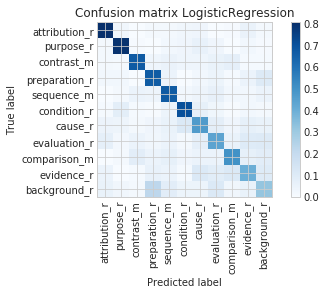

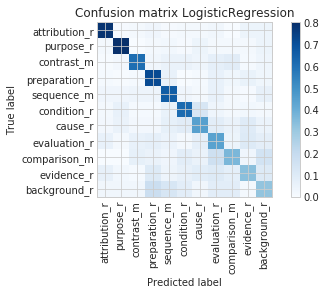

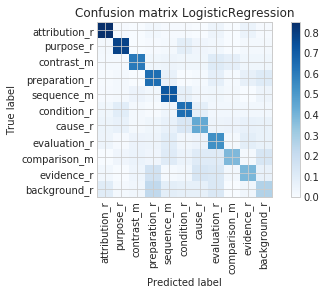

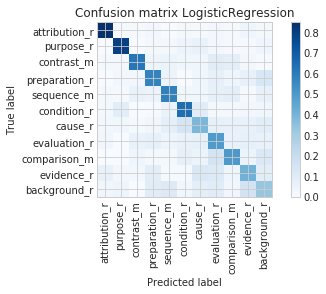

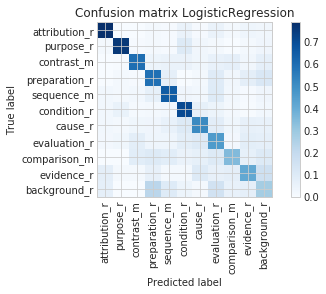

In [22]:
results, classifiers, reports = train_stratified([logreg], X, y, nsplits=5, confusion=True)
describe_cv_result(results)

In [26]:
describe_reports(reports)

           attribution_r  background_r     cause_r  comparison_m  condition_r  \
f1-score        0.815584      0.227638    0.569894      0.345567     0.688516   
precision       0.793251      0.271992    0.618446      0.510852     0.665314   
recall          0.839316      0.197222    0.528514      0.263333     0.713939   
support       117.000000     72.000000  249.000000     60.000000   165.000000   

           contrast_m  evaluation_r  evidence_r  preparation_r   purpose_r  \
f1-score     0.735137      0.460552    0.347514       0.669232    0.791044   
precision    0.778713      0.396650    0.361590       0.647065    0.789945   
recall       0.696482      0.549296    0.335000       0.693827    0.793333   
support    199.000000    142.000000   80.000000     162.000000  120.000000   

           sequence_m  accuracy    macro avg  weighted avg  
f1-score     0.658279  0.616242     0.573542      0.612426  
precision    0.604640  0.616242     0.585314      0.618539  
recall       0.72258

## Save the cool one 

In [34]:
from utils.train_test_split import split_data

train, test = split_data('data/', 0.2)

news in train: 0.38114754098360654, in test: 0.3114754098360656
ling in train: 0.1680327868852459, in test: 0.14754098360655737
comp in train: 0.13114754098360656, in test: 0.22950819672131148


In [18]:
import pandas as pd

random_state = 41

train_samples = []
test_samples = []

for file in train:
    train_samples.append(pd.read_pickle(file.replace('.edus', '.gold.pkl')))

for file in test:
    test_samples.append(pd.read_pickle(file.replace('.edus', '.gold.pkl')))

train_samples = pd.concat(train_samples).sample(frac=1, random_state=random_state).reset_index(drop=True)
test_samples = pd.concat(test_samples).sample(frac=1, random_state=random_state).reset_index(drop=True)

In [19]:
train_samples.category_id.value_counts()

joint_m                        5924
elaboration_r                  5923
cause_r                        1743
contrast_m                     1592
condition_r                    1329
preparation_r                  1306
purpose_r                       999
evaluation_r                    954
sequence_m                      935
attribution_r                   915
same-unit_m                     884
evidence_r                      656
background_r                    577
comparison_m                    495
solutionhood_r                  301
concession_r                    277
restatement_m                   236
cause-effect_r                  236
interpretation-evaluation_r     114
effect_r                         28
antithesis_r                     20
conclusion_r                      5
motivation_r                      1
Name: category_id, dtype: int64

In [20]:
TARGET = 'category_id'

train_samples[TARGET] = train_samples[TARGET].replace(['cause-effect_r', 'effect_r'], 'cause_r')
train_samples[TARGET] = train_samples[TARGET].replace(['interpretation-evaluation_r', 'conclusion_r'], 'evaluation_r')
test_samples[TARGET] = test_samples[TARGET].replace(['cause-effect_r', 'effect_r'], 'cause_r')
test_samples[TARGET] = test_samples[TARGET].replace(['interpretation-evaluation_r', 'conclusion_r'], 'evaluation_r')

y_stat = train_samples[TARGET].value_counts()
drop_ys = y_stat[y_stat < 100].index

for dy in drop_ys:
    train_samples = train_samples[train_samples[TARGET] != dy]
    
y_stat = test_samples[TARGET].value_counts()
drop_ys = y_stat[y_stat < 100].index

for dy in drop_ys:
    test_samples = test_samples[test_samples[TARGET] != dy]

In [22]:
drop_columns = pickle.load(open('models/label_predictor/drop_columns.pkl', 'rb'))

In [23]:
TARGET = 'category_id'
y_train, X_train = train_samples[TARGET].to_frame(), train_samples.drop(TARGET, axis=1).drop(columns=drop_columns)
y_test, X_test = test_samples[TARGET].to_frame(), test_samples.drop(TARGET, axis=1).drop(columns=drop_columns)

In [ ]:
scaler = StandardScaler().fit(X_train)

X_scaled_np = scaler.transform(X_train)
X_train = pd.DataFrame(X_scaled_np, index=X_train.index)#, columns=X.columns)

X_scaled_np = scaler.transform(X_test)
X_test = pd.DataFrame(X_scaled_np, index=X_test.index)#, columns=X.columns)

pickle.dump(scaler, open('models/label_predictor/scaler.pkl', 'wb'))

In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

lab_encoder = LabelEncoder()
y_train = lab_encoder.fit_transform(y_train)
pickle.dump(lab_encoder, open('models/label_predictor/label_encoder.pkl', 'wb'))

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
train_samples.category_id.value_counts()

joint_m           5924
elaboration_r     5923
cause_r           2007
contrast_m        1592
condition_r       1329
preparation_r     1306
evaluation_r      1073
purpose_r          999
sequence_m         935
attribution_r      915
same-unit_m        884
evidence_r         656
background_r       577
comparison_m       495
solutionhood_r     301
concession_r       277
restatement_m      236
Name: category_id, dtype: int64

In [90]:
weights = [25., 25., 8.5, 6.75, 5.6, 5.5, 4.5, 4.25, 4., 4., 3.75, 3., 2.5, 2.1, 1.3, 1., 1.]

In [91]:
catboost = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.2,
    custom_loss=['F1'],
    random_seed=random_state,
    verbose=0,
    loss_function='MultiClass',
    task_type='GPU',
    class_weights=weights
)

fs_catboost = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(solver='saga', penalty='l1', C=1., n_jobs=-1))),
  ('classification', catboost)
])

logreg = LogisticRegression(random_state=random_state,
                            solver='lbfgs',
                            n_jobs=-1,
                            C=0.001,
                            multi_class='multinomial',
                            class_weight='balanced')

fs_catboost_plus_logreg = VotingClassifier([('fs_catboost', fs_catboost), ('logreg', logreg)], voting='soft')

In [ ]:
fs_catboost_plus_logreg.fit(X_train, y_train)

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [102]:
pickle.dump(fs_catboost_plus_logreg, open('models/label_predictor/model.pkl', 'wb'))

In [11]:
import pickle

fs_catboost_plus_logreg = pickle.load(open('models/label_predictor/model.pkl', 'rb'))
lab_encoder = pickle.load(open('models/label_predictor/label_encoder.pkl', 'rb'))
scaler = pickle.load(open('models/label_predictor/scaler.pkl', 'rb'))

In [28]:
from sklearn import metrics

predicted = lab_encoder.inverse_transform(fs_catboost_plus_logreg.predict(scaler.transform(X_test)))

print('weighted f1: ', metrics.f1_score(y_test.values, predicted, average='weighted'))
print('macro f1: ', metrics.f1_score(y_test.values, predicted, average='macro'))
print('accuracy: ', metrics.accuracy_score(y_test.values, predicted))
print()
print(metrics.classification_report(y_test, predicted))

weighted f1:  0.5257588933931949
macro f1:  0.3810695760278998
micro f1:  0.5364317330609465
accuracy:  0.5364317330609465

                precision    recall  f1-score   support

 attribution_r       0.71      0.78      0.74       253
  background_r       0.16      0.08      0.10       146
       cause_r       0.50      0.46      0.48       485
  comparison_m       0.24      0.16      0.19       102
  concession_r       0.00      0.00      0.00         0
   condition_r       0.57      0.68      0.62       317
    contrast_m       0.71      0.65      0.68       398
 elaboration_r       0.50      0.66      0.57      1337
  evaluation_r       0.38      0.28      0.32       347
    evidence_r       0.46      0.19      0.27       140
       joint_m       0.57      0.61      0.59      1322
 preparation_r       0.50      0.39      0.44       319
     purpose_r       0.70      0.74      0.72       205
 restatement_m       0.00      0.00      0.00         0
   same-unit_m       0.52      0.30

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4. Important features exploration

In [ ]:
useless = []
for classifier in classifiers:
    fi = np.array(classifier.feature_importances_)
    sorted_idx = np.argsort(fi)
    print('nonzero:', np.count_nonzero(fi))

    pd.set_option('display.max_rows', 150)
    dd = pd.DataFrame({'Feature': np.array(X.keys())[sorted_idx], 'Importance': fi[sorted_idx][::-1]})
    dd = dd[dd['Importance'] == 0]
    useless.append(dd.Feature.tolist())

In [ ]:
useless

In [ ]:
classifier = classifiers[0]

In [ ]:
classifier = classifiers[0].estimators[0][1]._final_estimator

In [ ]:
fi = np.array(classifier.feature_importances_)
sorted_idx = np.argsort(fi)
print(np.count_nonzero(fi))

pd.set_option('display.max_rows', 150)
dd = pd.DataFrame({'Feature': np.array(X.keys())[sorted_idx], 'Importance': fi[sorted_idx][::-1]})
dd = dd[dd['Importance'] > 0]

In [ ]:
null_import = dd.Feature.values

In [ ]:
null_import.sort()

In [ ]:
null_import

In [ ]:
[key for key in null_import if '_count_y' in key]

In [ ]:
[key for key in null_import if '_count_x' in key]

In [ ]:
lexical = pd.concat([dd[dd.Feature.str.contains('tf_idf')], 
                     dd[dd.Feature.str.contains('upper_')],
                     dd[dd.Feature.str.contains('jac')],
                     dd[dd.Feature.str.contains('len')]]).drop_duplicates()
lexical = list(lexical.Feature)
print(len(lexical), lexical)

In [ ]:
morphosynt = pd.concat([dd[dd.Feature.str.islower() == False],
                        dd[dd.Feature.str.contains('morph')]]).drop_duplicates()
morphosynt = morphosynt.replace(['tf_idf_', 'upper', 'len_', 'stopwords'], np.NaN, regex=True).dropna()
morphosynt = morphosynt[morphosynt.Feature.str[-2:] != '_X']
morphosynt = morphosynt[morphosynt.Feature.str[-2:] != '_Y']

morphosynt = list(morphosynt.Feature)
print(len(morphosynt), morphosynt)

In [ ]:
textual = pd.concat([dd[dd.Feature.str[-2:] == '_X'],
                     dd[dd.Feature.str[-2:] == '_Y'],
                     dd[dd.Feature.str.contains('stopwords')]])
textual2 = pd.concat([dd[dd.Feature.str.contains('first')],
                      dd[dd.Feature.str.contains('last')]])
textual2 = textual2[textual2.Feature.str.islower()]
textual = pd.concat([textual, textual2])
textual = textual.replace(['tf_idf_', 'upper', 'len_', 'fPOS'], np.NaN, regex=True).dropna()

textual = list(textual.Feature)
print(len(textual), textual)

In [ ]:
textX = textual[textual.Feature.str[-2:] == '_x']
textY = textual[textual.Feature.str[-2:] == '_y']
firstPX = textX[textX.Feature.str.contains('first_pair')]
firstPY = textY[textY.Feature.str.contains('first_pair')]
lastPX = textX[textX.Feature.str.contains('last_pair')]
lastPY = textY[textY.Feature.str.contains('last_pair')]
countPX = textual[textual.Feature.str.contains('_X')]
countPY = textual[textual.Feature.str.contains('_Y')]

len(firstPX), len(firstPY), len(lastPX), len(lastPY), len(countPX), len(countPY)

In [ ]:
for _ in [lexical, morphosynt, textual]:
    print(len(_) / dd.shape[0] * 100)

In [ ]:
model = CatBoostClassifier(
    iterations=1800,
    learning_rate=0.2,
    custom_loss=['F1'],
    random_seed=random_state,
    verbose=2,
    loss_function='MultiClass',
    task_type='GPU'
)

In [ ]:
result = {
    feature: 0 for feature in X.keys()
}

In [ ]:
#result = pd.DataFrame({'feature': X.keys(), 'score': np.zeros(X.shape[1])})

kf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train, test in kf.split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y[train], y[test]
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    fi = np.array(model.feature_importances_)
    sorted_idx = np.argsort(fi)
    dd = pd.DataFrame({'Feature': np.array(X.keys())[sorted_idx], 'Importance': fi[sorted_idx][::-1]})
    dd = dd[dd['Importance'] > 0].Feature.values
    for feat in dd:
        result[feat] += 1

In [ ]:
rr = pd.DataFrame.from_dict(result, orient='index')
rr[rr[0] > 0].index.values

In [ ]:
rr[rr[0] > 0]

In [ ]:
list(rr[rr[0] == 0].index.values)

### 5. Feature selection

In [ ]:
! pip install feature_selector

In [ ]:
from feature_selector import FeatureSelector

fs = FeatureSelector(data=X, labels=y)

In [ ]:
fs.identify_missing(missing_threshold=0.01)

####  - Find features with single unique value

In [ ]:
fs.identify_single_unique()

In [ ]:
# list of single unique values features
fs.ops['single_unique']

#### - Find collinear features

In [ ]:
X.iloc[:, :10].shape

In [ ]:
X.shape

In [ ]:
fs = FeatureSelector(data=X.iloc[:, 1400:1800], labels=y)
fs.identify_collinear(correlation_threshold=.98, one_hot=False)

In [ ]:
# list of collinear features to remove
fs.ops['collinear']

In [ ]:
tom = fs.corr_matrix[['last_pair_извест(?:ен|но)_x']]

In [ ]:
aa = tom > 0.9

In [ ]:
tom[aa['last_pair_извест(?:ен|но)_x']]

### 6. Symmetry regressor implementation

In [ ]:
import pandas as pd

df = pd.read_pickle(PATH+DATAFILE)
TARGET = 'category_id'

def get_classes(df, y_name, classes):
    res = []
    for class_name in classes:
        res.append(df[df[y_name] == class_name])

    return pd.concat(res).sample(frac=1).reset_index(drop=True)

for_bin_regr = [
    'joint_m',
    'elaboration_r',
    'restatement_m',
    'concession_r',
    'solutionhood_r',
    'antithesis_r',
]

df_bin = get_classes(df, 'category_id', for_bin_regr)

In [ ]:
TARGET = 'category_id'

names = list(df[TARGET].unique())

replace_map = {
    TARGET: {
        k: v for k, v in [(name, name[-1]) for name in names]
    }
}

df_bin = df_bin.replace(replace_map).replace({TARGET: {'r': 0, 'm': 1}})

In [ ]:
df_bin.category_id.value_counts()

In [ ]:
TARGET = 'category_id'

y_bin, X_bin = df_bin[TARGET].to_frame(), df_bin.drop(TARGET, axis=1).drop(columns=['snippet_x', 'snippet_y', 'snippet_x_tmp', 'snippet_y_tmp', 'order', 'filename'])

In [ ]:
lgbm_param_bin =  {
    'tree_learner': 'feature',
    'task': 'train',
    'random_state': random_state,
    'metric': 'binary_logloss',
    'feature_fraction': 0.8,
    'colsample_bytree' : 0.8,
    'boosting_type': 'dart',
    'application': 'regression',
    'num_iterations': 150
}

lgb_bin_class = lgb.LGBMClassifier(**lgbm_param_bin)

X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, shuffle=True, test_size=.1, random_state=random_state)

feature_selector = SelectFromModel(LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1'))
model_single = Pipeline([('feature_selector', feature_selector), 
                         ('classifier', lgb_bin_class)])

model = BaggingClassifier(base_estimator=model_single, 
                          n_estimators=7,
                          max_samples=1.0, 
                          max_features=0.6, 
                          bootstrap=True, 
                          random_state=random_state)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
print(metrics.classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

In [ ]:
filename = 'symmetry_predictor.save'
pickle.dump(model, open(PATH + filename, 'wb'))

### 7. Classifiers parameters tuning

#### - GridSearch

In [ ]:
param_grid = {'C': [0.0001, 0.005, 0.001] }
clf = GridSearchCV(LinearSVC(random_state=random_state), param_grid, cv=5, verbose=2)
clf.fit(X.values, y.values.ravel())

In [ ]:
clf.best_params_

#### - RandomSearch 

In [ ]:
lgb_model = lgb.LGBMClassifier()

lgbm_param =  {
    'task': ['train'],
    'boosting_type': ['gbdt'],
    'objective': ['multiclass'],
    'num_class': [6,],
    'metric': ['multi_error'],
    "learning_rate": list(np.arange(0.05, 1, 0.25)),
    "num_leaves": list(range(32, 128, 16)),
    "max_depth": list(range(2, 17, 2)),
    "reg_alpha": [.15],
    "reg_lambda": [.15],
}

clf = RandomSearchCV(lgb_model, lgbm_param, n_jobs=8, cv=5)
clf.fit(scaling.transform(X.values), y.values.ravel())

print("Best parameters:")
print(clf.best_params_)
print()
print("Grid score:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

## Nuclearity types classification

1. Data cleaning: obtain the data and clean it (X, y)
 - transformations: normalization, scaling
2. Classifiers & CV-training

#### 1. Data cleaning 

In [ ]:
df = pd.read_pickle(PATH+DATAFILE)
TARGET = 'order'
df[TARGET].value_counts()

In [ ]:
unique_type_list = df[TARGET].unique()
replace_map = {TARGET : {k: v for k,v in zip(unique_type_list, list(range(0,len(unique_type_list))))}}
y, X = df[TARGET].to_frame(), df.drop(TARGET, axis=1).drop(columns=['snippet_x', 'snippet_y', 'snippet_x_tmp', 'snippet_y_tmp', 'filename', 'category_id'])

In [ ]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
scl = StandardScaler().fit(X.values)

X_scaled_np = scl.transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled_np, index=X.index, columns=X.columns)

X = X_scaled_df

#### 2. Classifiers & CV-training

In [ ]:
lsvc = LinearSVC(random_state=random_state, C=0.001)
logreg = LogisticRegression(random_state=random_state,
                            solver='lbfgs',
                            n_jobs=8,
                            C=0.001,
                            multi_class='auto')

lgbm_param =  {
    'tree_learner': 'feature',
    'task': 'train',
    'scale_pos_weight': 155,
    'reg_lambda': 0.11,
    'reg_alpha': 0.11,
    'random_state': random_state,
    'num_leaves': 36,
    'num_class': 3,
    'min_split_gain': 0.76,
    'min_child_weight': 0.11,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'feature_fraction': 0.45,
    'boosting_type': 'dart',
    'bagging_fraction': 0.9,
    'application': 'multiclass',
    'num_iterations': 500,
}
lgb_class = lgb.LGBMClassifier(**lgbm_param)
     
lgbm_plus_bagger_lsvc = VotingClassifier([('LGBM', lgb_class), ('bagger', bagger_lsvc)], voting='soft')

def construct_simple_nn_classifier(input_length, output_length):
    input_features = Input(shape=(input_length,))
    l = Dense(100, kernel_initializer='he_uniform')(input_features)
    l = Activation('relu')(l)
    l = BatchNormalization(axis = 1)(l)
    l = Dropout(0.5)(l)
    outputs = Dense(output_length, activation='softmax')(l)

    model = SklearnWrapperKerasEstimator(inputs=[input_features], outputs=outputs)
    adam = Adam(lr=0.001, amsgrad=True)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['mean_squared_error', 'acc'])

    return model
  
nnclassifier = construct_simple_nn_classifier(input_length=X.shape[1], output_length=len(np.unique(y)))

catboost = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    custom_loss=['F1'],
    random_seed=random_state,
    verbose=0,
    loss_function='MultiClass',
    task_type='GPU',
)

fs_catboost = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', C=1.))),
  ('classification', catboost)
])

fs_lgbm = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', C=1.))),
  ('classification', lgb_class)
])

nnclassifier_smote = Pipeline([('smt', smt), ('nnclassifier', nnclassifier)])

name = lambda x : str(x).split('(')[0]

In [ ]:
results, classifiers, reports = train_stratified([nnclassifier_smote, 
                                                  logreg, 
                                                  lsvc, 
                                                  catboost, 
                                                  lgb_class, 
                                                  fs_catboost, 
                                                  fs_lgbm], X, y, nsplits=5, confusion=False)

describe_cv_result(results)

### Genre classification and feature selection 

In [ ]:
df.head()

In [ ]:
df.filename = df.filename.map(lambda row: row.split('_')[0])

In [ ]:
y, X = df['filename'].to_frame(), df.drop(
    columns=[TARGET, 'snippet_x', 'snippet_y', 'snippet_x_tmp', 'snippet_y_tmp', 
             'filename', 'order', 'postags_x', 'postags_y'])

In [ ]:
catboost = CatBoostClassifier(
    iterations=1800,
    learning_rate=0.2,
    custom_loss=['F1'],
    random_seed=random_state,
    verbose=2,
    loss_function='MultiClass',
    task_type='GPU',
    plot=True
)

X_train, X_test, y_train, y_test = train_test_split(X, y)
catboost.fit(X_train, y_train, eval_set=(X_test, y_test))

In [ ]:
print(metrics.classification_report(catboost.predict(X_test), y_test))

In [ ]:
fi = np.array(catboost.feature_importances_)
sorted_idx = np.argsort(fi)
print(np.count_nonzero(fi))

pd.set_option('display.max_rows', 150)
dd = pd.DataFrame({'Feature': np.array(X.keys())[sorted_idx], 'Importance': fi[sorted_idx][::-1]})
dd = dd[dd['Importance'] > 0]

In [ ]:
dd